In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
import os
import yaml
import ot
import json
from tqdm import tqdm
import pandas as pd
sys.path.append(".")
sys.path.append("../")
sys.path.append("../../")
import numpy as np
import src.utils.io as io   
import src.utils.functionalities as func
import torch
import config as config
from sklearn.preprocessing import LabelEncoder
from src.utils.plots import multi_label_predictions, plot_multiclass_roc
import src.utils.preprocess as preprocess
from src.eval.eval_utils import evaluate_multilabel_distribution
from torch.utils.data import DataLoader
from src.methods.coral import SimpleFeatureNet
from src.eval.plot_utils import make_vectronics_plots_from_model, make_sightings_plots_from_clusters, make_sightings_plots_from_model
from src.methods.calibration import calibration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Graphing Parameters
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25
mpl.rcParams["axes.labelsize"] = 25
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['text.usetex'] = True

In [6]:
with open(config.VECTRONICS_PREPROCESSING_YAML) as f:
    Vectronics_preprocessing_config = yaml.safe_load(f)
Vectronics_feature_cols = Vectronics_preprocessing_config['feature_cols']

# load labeled vectronics data
min_duration_before_padding = 15.0
print("Loading lableded source data (Vectronics)...")
labeled_vectronics_df = pd.read_csv(io.get_Vectronics_preprocessed_path(min_duration_before_padding))
X_src = labeled_vectronics_df[Vectronics_feature_cols].values
y_src = labeled_vectronics_df['behavior'].values
label_encoder = LabelEncoder()
y_src = label_encoder.fit_transform(y_src)
y_src = y_src

# load full unlabaled vectronics data
print("Loading unlableded source data (Vectronics)...")
X_src_full = pd.read_csv(io.get_Vectronics_full_summary_path())

print("Loading target data (RVC)...")
RVC_df = pd.read_csv(io.get_RVC_preprocessed_path())
RVC_df = RVC_df.drop_duplicates().reset_index(drop=True)

cols = ['feeding_binary', 'moving_binary', 'resting_binary']
RVC_df[cols] = RVC_df[cols].fillna(0)
RVC_df['behavior'] = np.select(
    [
        RVC_df['feeding_binary'] == 1,
        RVC_df['moving_binary'] == 1,
        RVC_df['resting_binary'] == 1
    ],
    ['Feeding', 'Moving', 'Stationary'], default=None) 

labeled_mask = RVC_df['behavior'].notna()

Loading lableded source data (Vectronics)...
Loading unlableded source data (Vectronics)...
Loading target data (RVC)...


In [7]:
left_limit = np.quantile(X_src, 0.0, axis=0)
right_limit = np.quantile(X_src, 1.0, axis=0)
right_limit = np.where(right_limit == left_limit, left_limit + 1e-6, right_limit)

Xt = RVC_df[Vectronics_feature_cols].values
mask = (Xt >= left_limit).all(axis=1) & (Xt <= right_limit).all(axis=1) & (Xt > 0.0).all(axis=1)
RVC_df = RVC_df[mask].reset_index(drop=True)

Xs = X_src_full[Vectronics_feature_cols].values
mask = (Xs >= left_limit).all(axis=1) & (Xs <= right_limit).all(axis=1)  & (Xs > 0.0).any(axis=1)
X_src_full = X_src_full[mask].reset_index(drop=True)

X_targets = [RVC_df.loc[RVC_df.firmware_major_version == 2.0].reset_index(drop=True),
              RVC_df.loc[RVC_df.firmware_major_version == 3.0].reset_index(drop=True)]

print(len(X_src_full))
print(len(X_targets[0]))
print(len(X_targets[1]))

4284008
1176203
4405492


In [8]:
labeled_mask = RVC_df['behavior'].notna()
RVC_labeled_df = RVC_df[labeled_mask]
X_labeled_targets = [RVC_labeled_df.loc[RVC_labeled_df.firmware_major_version == 2.0][Vectronics_feature_cols].values,
                            RVC_labeled_df.loc[RVC_labeled_df.firmware_major_version == 3.0][Vectronics_feature_cols].values]
y_labeled_targets = [RVC_labeled_df.loc[RVC_labeled_df.firmware_major_version == 2.0]['behavior'].values,
                            RVC_labeled_df.loc[RVC_labeled_df.firmware_major_version == 3.0]['behavior'].values]
y_labeled_targets = [label_encoder.transform(y) for y in y_labeled_targets]

In [9]:
# --------------------------
# Preprocess (compute quantiles using all domains)
# --------------------------
pos_idx = [0, 1, 2, 3, 4, 5]  # Indices of features that should be positive
center_idx = None  # Indices of features that should be centered at zero

# compute global lows/highs once
lows, highs = preprocess.compute_combined_quantiles(
    datasets=[X_src],
    pos_idx=[0,1,2,3,4,5], center_idx=None,
    low_q=0.00,
    high_q=1.00,
)

# define transform
transform = preprocess.TransformAndScale(
    pos_idx=pos_idx,
    center_idx=center_idx,
    lows=lows,
    highs=highs,
    clip_to_quantile=False
)

In [10]:
X_src, y_src = torch.tensor(X_src, dtype=torch.float32), torch.tensor(y_src, dtype=torch.float32)
X_src = transform(X_src)
Xt1 = transform(torch.tensor(X_targets[0][Vectronics_feature_cols].values, dtype=torch.float32))
Xt2 = transform(torch.tensor(X_targets[1][Vectronics_feature_cols].values, dtype=torch.float32))

source_loader = DataLoader(transform(torch.tensor(X_src_full[Vectronics_feature_cols].values, dtype=torch.float32)), batch_size=1024, shuffle=True, num_workers=4, pin_memory=True)
target_loaders = [DataLoader(Xt1, batch_size=1024, shuffle=True, num_workers=4, pin_memory=True),
                  DataLoader(Xt2, batch_size=1024, shuffle=True, num_workers=4, pin_memory=True) ]

In [11]:
N_CLUSTERS, CLUSTER_BATCH_SIZE = 100, 10000
feat_dim = 128
reg = 0.01

cluster_dist1, cluster_centroids1, cluster_labels1, kmeans1 = func.compute_kmeans_distribution(Xt1, n_clusters=N_CLUSTERS, batch_size=CLUSTER_BATCH_SIZE, random_state=42)
cluster_dist2, cluster_centroids2, cluster_labels2, kmeans2 = func.compute_kmeans_distribution(Xt2, n_clusters=N_CLUSTERS, batch_size=CLUSTER_BATCH_SIZE, random_state=42)
label_dist = np.array([2.55, 4.48, 3.55, 1.96, 87.45])

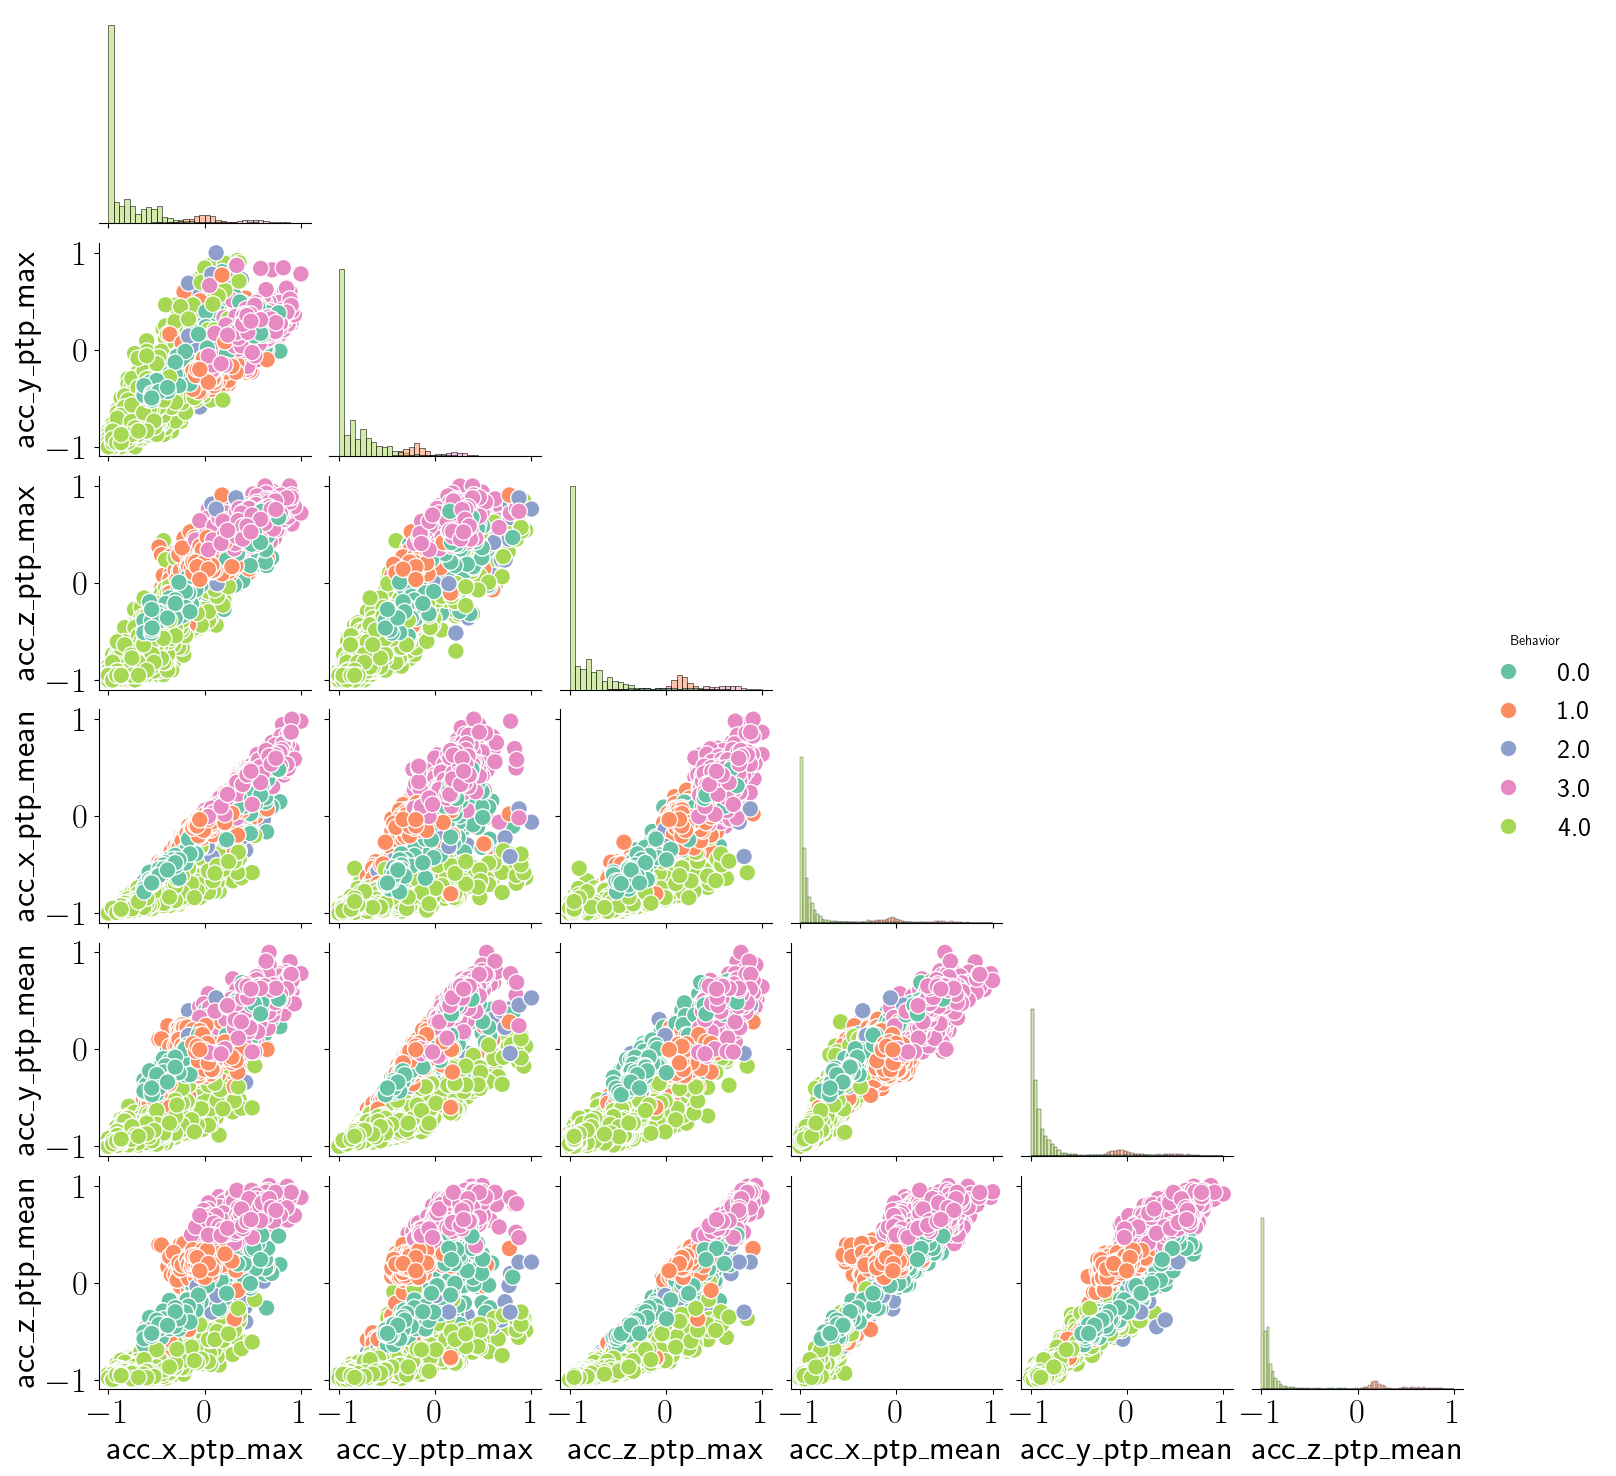

In [11]:
X_df = pd.DataFrame(X_src, columns=Vectronics_feature_cols)
X_df['Behavior'] = y_src

sns.pairplot(X_df, hue='Behavior', corner=True, diag_kind='hist', palette='Set2')
plt.show()


/tmp/ipykernel_213644/185205029.py:63: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


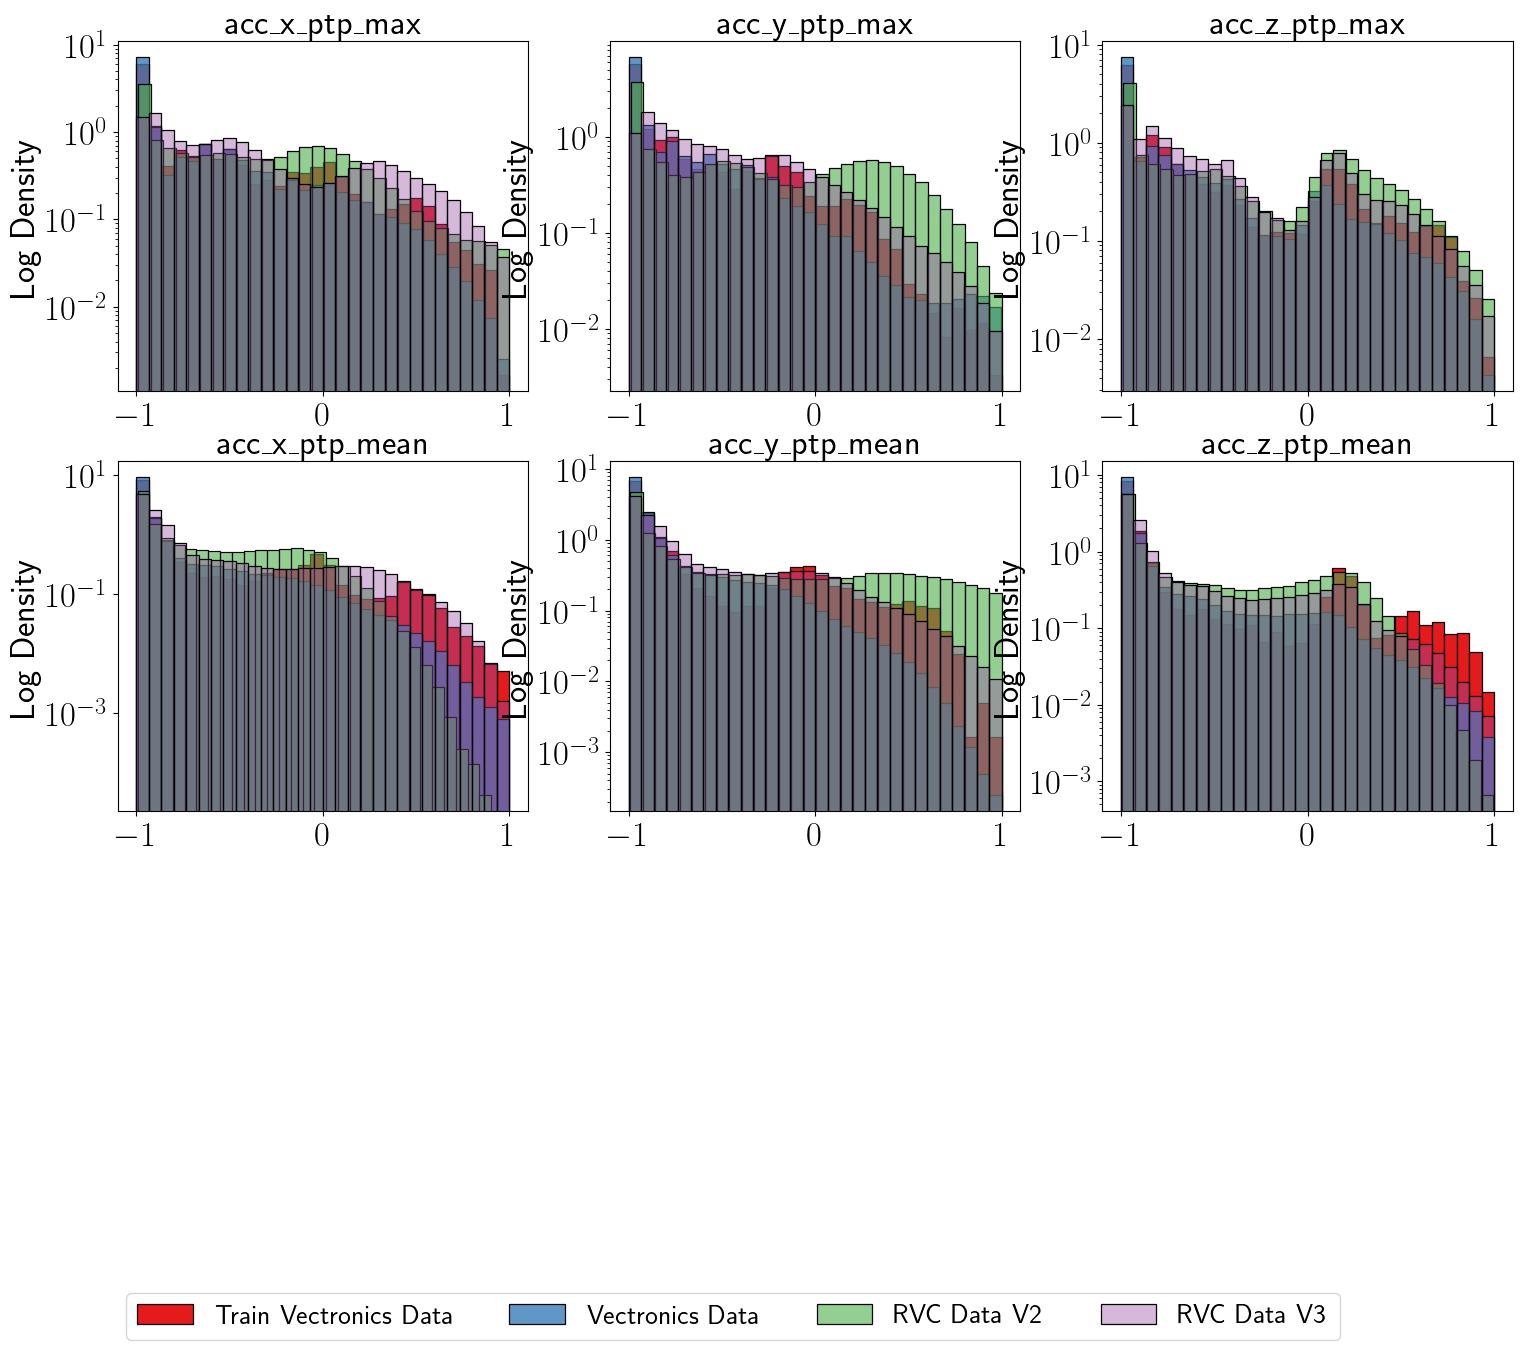

In [ ]:
# Plot histograms of features
fig, axes = plt.subplots(len(Vectronics_feature_cols)//3, 3, figsize=(18, 5*(len(Vectronics_feature_cols)//3)))

palette = sns.color_palette("Set1", n_colors=4)
axes = axes.flatten()

Xt1 = transform(torch.tensor(X_targets[0][Vectronics_feature_cols].values, dtype=torch.float32))
Xt2 = transform(torch.tensor(X_targets[1][Vectronics_feature_cols].values, dtype=torch.float32))
Xs = transform(torch.tensor(X_src_full[Vectronics_feature_cols].values, dtype=torch.float32))

for i, col in enumerate(Vectronics_feature_cols):
        ax = axes[i]

        sns.histplot(
                X_src[:,i].numpy(),
                kde=False,
                label='Train Vectronics Data',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[0],
                alpha=1.0
            )
        
        sns.histplot(
                Xs[:,i].numpy(),
                kde=False,
                label='Vectronics Data',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[1],
                alpha=0.8
            )

        sns.histplot(Xt1[:,i].numpy(),
                kde=False,
                label='RVC Data V2',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[2],
                alpha=0.6
            )
        sns.histplot(Xt2[:,i].numpy(),
                kde=False,
                label='RVC Data V3',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[3],
                alpha=0.4
            )
    
        ax.set_title(col)
        ax.set_ylabel('Log Density')
        ax.set_yscale("log")
        ax.set_xlabel('')

# Get legend info from the first axes
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels, loc='lower center', bbox_to_anchor=(1.5, -2.75), ncol=4)

plt.tight_layout()
plt.show()


In [12]:
# objects for evaluation

sightings = pd.read_csv(io.get_sightings_path())
matched_gps = pd.read_csv(io.get_matched_gps_path())
gps_moving = pd.read_csv(io.get_gps_moving_path())
gps_clusters = pd.read_csv(io.get_gps_clusters_path())

group_ids = list(sightings.groupby(['animal_id', 'UTC date [yyyy-mm-dd]']).groups.keys())
n_sightings_days = len(group_ids)
train_sightings, val_sightings, test_sightings = group_ids[:int(0.5*n_sightings_days)], group_ids[int(0.5*n_sightings_days): int(0.75*n_sightings_days)], group_ids[int(0.75*n_sightings_days): ]
test_mask = RVC_labeled_df[['animal_id', 'UTC date [yyyy-mm-dd]']].apply(tuple, axis=1).isin(test_sightings)
X_sightings_test_set, y_sightings_test_set = RVC_labeled_df[test_mask][Vectronics_feature_cols].values, RVC_labeled_df[test_mask]['behavior'].values
y_sightings_test_set = label_encoder.transform(y_sightings_test_set)
print(X_sightings_test_set.shape, y_sightings_test_set.shape)

(6418, 6) (6418,)


## Method 1: CORAL

#### Model A

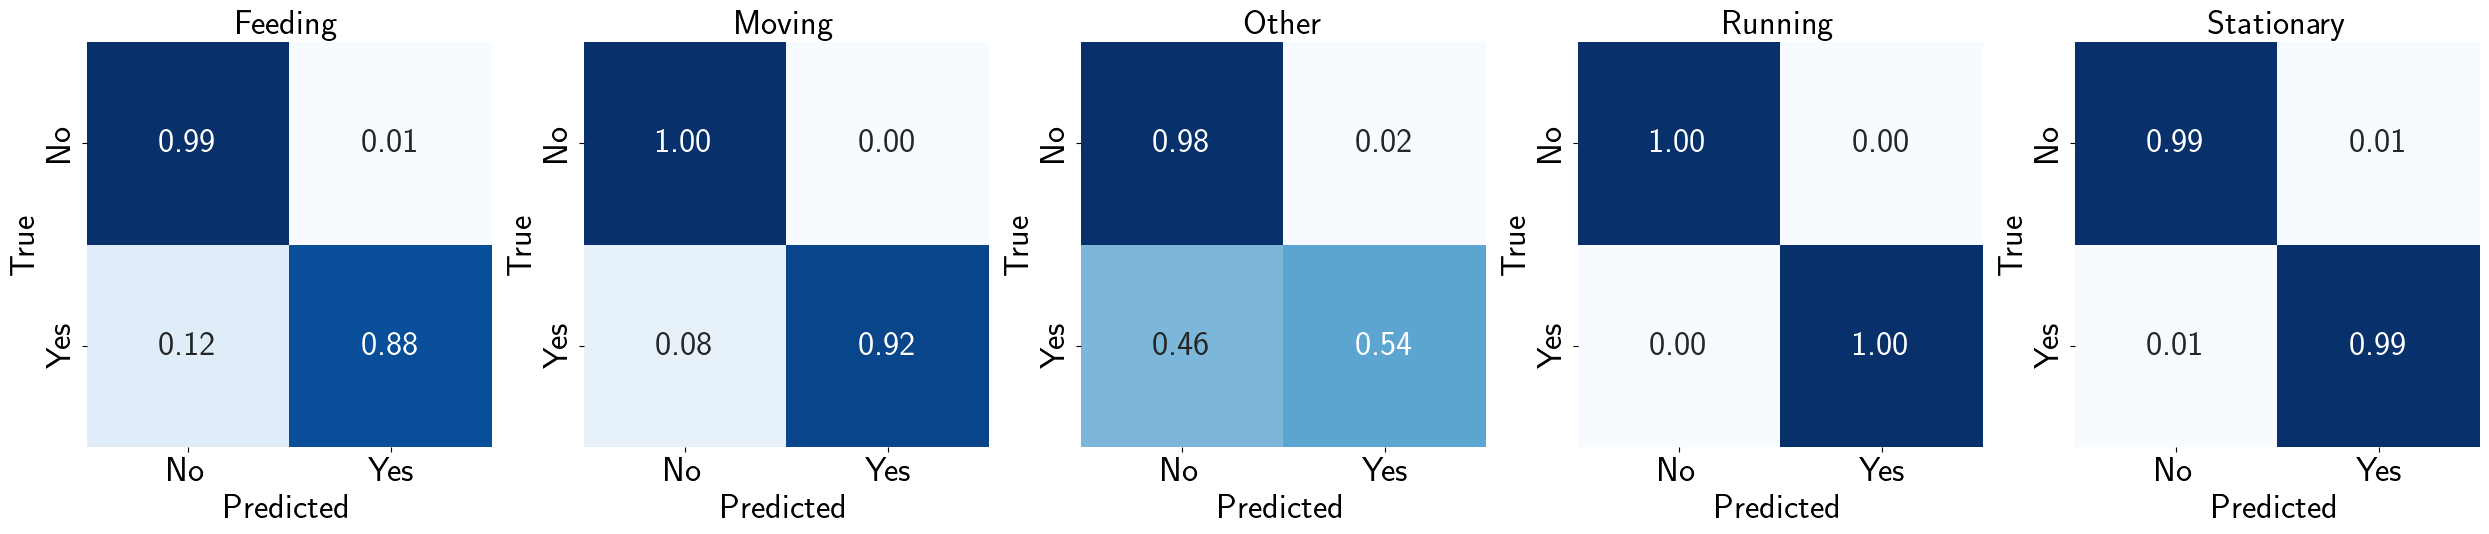

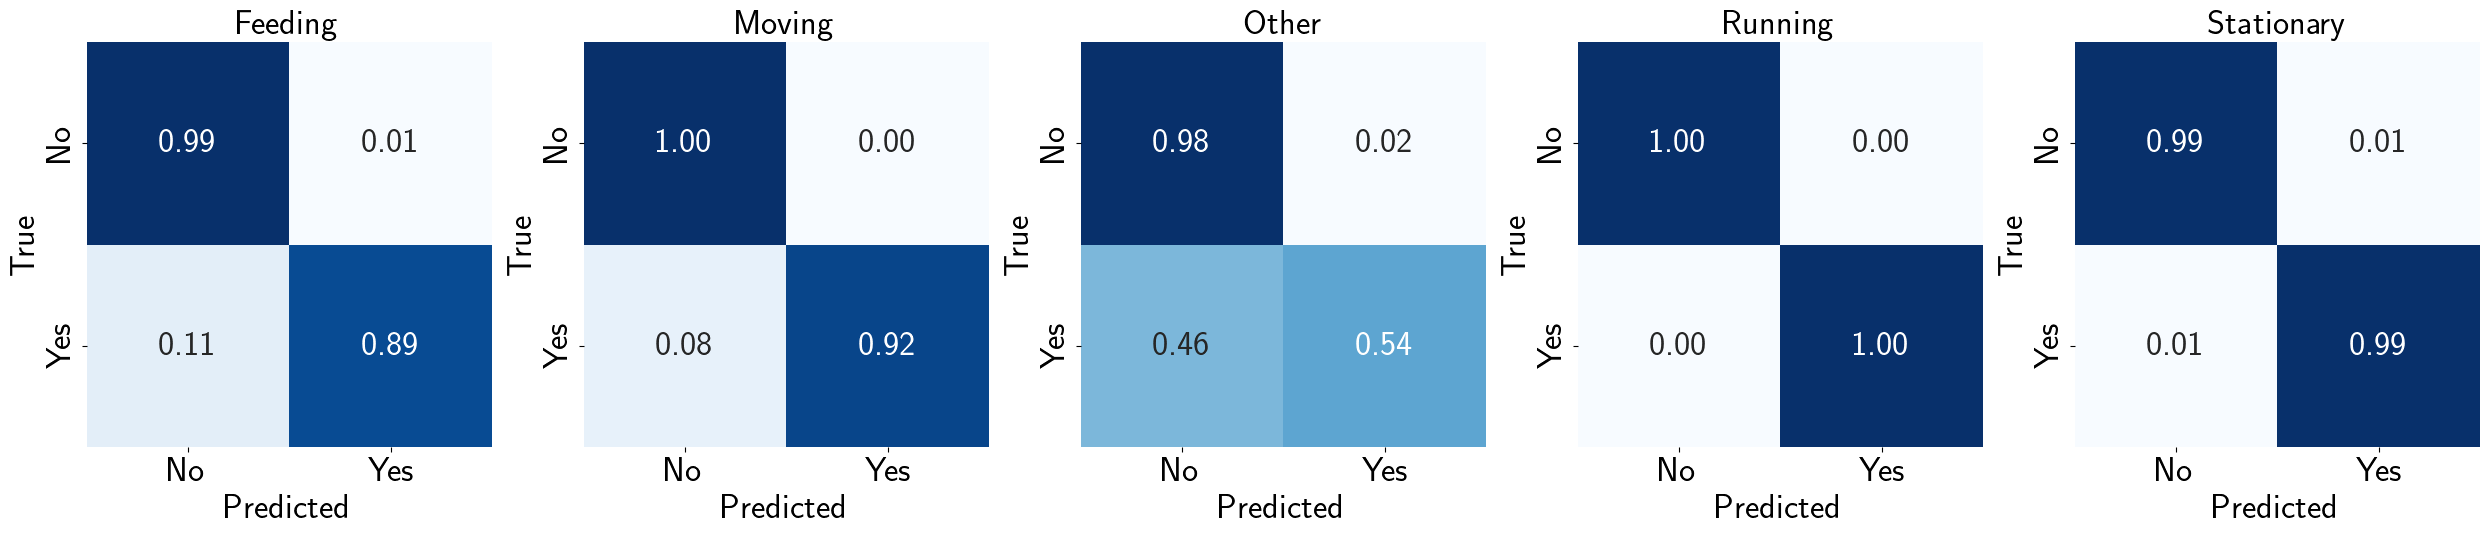

{}

In [66]:
model_name = 'A'
dir1 = os.path.join(io.get_domain_adaptation_results_dir(), "coral", model_name, "target1")
dir2 = os.path.join(io.get_domain_adaptation_results_dir(), "coral", model_name, "target2")

multi_label_predictions(dir1, label_encoder, split='test', plot_confusion=True, return_precision=False)
multi_label_predictions(dir2, label_encoder, split='test', plot_confusion=True, return_precision=False)


In [14]:
for row_idx, dir_path in enumerate([dir1, dir2]):

    # Load results
    results = np.load(os.path.join(dir_path, "test_results.npz"))
    y_true = results["true_classes"]        # shape: (N, C)
    y_pred = results["predictions"]         # shape: (N, C)
    print(np.sum(y_pred[np.where(y_true[:, 2] == 1)[0], :], axis=0))

[ 9  0 14  0  3]
[ 8  0 14  0  3]


In [87]:
feat_dim = 128

for i, dir_path in enumerate([dir1, dir2]):
    coral_model = SimpleFeatureNet(X_src.shape[-1], feat_dim, len(np.unique(y_src)))
    coral_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=device))
    coral_model.to(device)

    _, _, _ = evaluate_multilabel_distribution(model=coral_model, 
                                    data=target_loaders[i],
                                    label_encoder=label_encoder,
                                    device=device, 
                                    threshold=0.5)
    
    _, _, _ = evaluate_multilabel_distribution(model=coral_model, 
                                    data=source_loader,
                                    label_encoder=label_encoder,
                                    device=device, 
                                    threshold=0.5)

/tmp/ipykernel_755481/3596063052.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coral_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=


Predicted class % occurrence:
  Feeding: 11.36%
  Moving: 3.32%
  Other: 16.39%
  Running: 2.94%
  Stationary: 59.36%

Predicted class % occurrence:
  Feeding: 0.64%
  Moving: 7.82%
  Other: 2.90%
  Running: 1.60%
  Stationary: 85.94%


/tmp/ipykernel_755481/3596063052.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coral_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=


Predicted class % occurrence:
  Feeding: 4.69%
  Moving: 11.77%
  Other: 7.84%
  Running: 4.06%
  Stationary: 68.93%

Predicted class % occurrence:
  Feeding: 0.63%
  Moving: 8.39%
  Other: 2.83%
  Running: 1.61%
  Stationary: 85.32%


/tmp/ipykernel_712905/1698476298.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coral_model2.load_state_dict(torch.load(os.path.join(dir2, 'model.pt'), map_location=dev

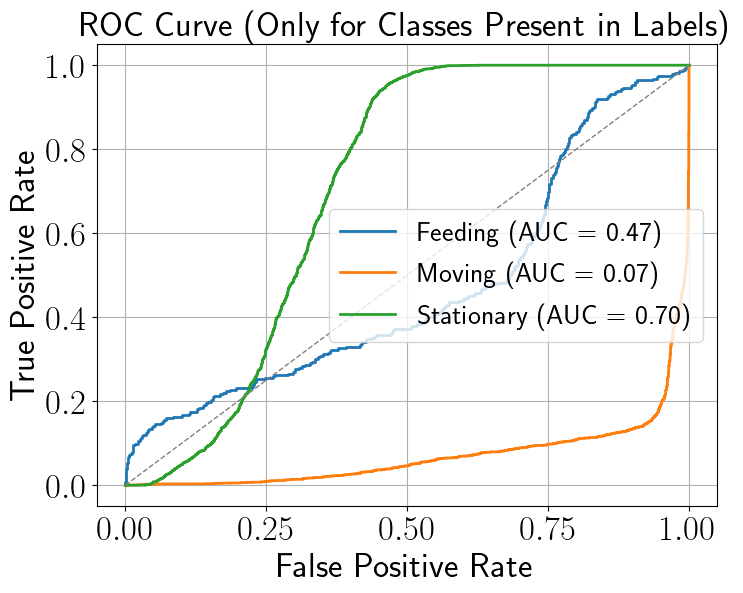

In [67]:
coral_model2 = SimpleFeatureNet(X_src.shape[-1], feat_dim, len(np.unique(y_src)))
coral_model2.load_state_dict(torch.load(os.path.join(dir2, 'model.pt'), map_location=device))
coral_model2.to(device)

with torch.no_grad():
    _, logits = coral_model2(torch.tensor(X_sightings_test_set, dtype=torch.float32).to(device))
    predictions = torch.sigmoid(logits).detach().cpu().numpy()

plot_multiclass_roc(y_sightings_test_set, predictions, label_encoder=label_encoder)

In [163]:
subset_df = RVC_df[RVC_df['animal_id'].isin(['Kigali', 'MJ', 'Timbuktu', 'Accra', 'Scorpion'])].copy()
subset_df['UTC date [yyyy-mm-dd'] = pd.to_datetime(subset_df['UTC date [yyyy-mm-dd]'])
start_date = pd.Timestamp('2012-04-01')
end_date   = pd.Timestamp('2012-06-30')
subset_df = subset_df.loc[(subset_df['UTC date [yyyy-mm-dd'] >= start_date) & (subset_df['UTC date [yyyy-mm-dd'] <= end_date)]
subset_X = transform(torch.tensor(subset_df[Vectronics_feature_cols].values, dtype=torch.float32)).to(device)

coral_model1 = SimpleFeatureNet(X_src.shape[-1], feat_dim, len(np.unique(y_src)))
coral_model1.load_state_dict(torch.load(os.path.join(dir1, 'model.pt'), map_location=device))
coral_model1.to(device)

P1, cluster_scores1, unadjusted_label_dist1, adjusted_label_dist1, adjusted_scores1, predictions1 = calibration(cluster_dist1, cluster_centroids1, cluster_labels1, coral_model1, label_dist=label_dist, reg=reg)


with torch.no_grad():
    _, logits = coral_model1(subset_X)
    scores = torch.sigmoid(logits)   
    uncalibrated_scores_np = scores.cpu().numpy()

subset_X_np = subset_X.cpu().numpy().astype(np.float64).copy() 
pred_labels = kmeans1.predict(subset_X_np)
calibrated_scores_np = adjusted_scores1[pred_labels]

uncalibrated_scores_df = pd.DataFrame(uncalibrated_scores_np, columns=["Uncalibrated "+b+" Score" for b in config.SUMMARY_BEHAVIORS], index=subset_df.index)
calibrated_scores_df = pd.DataFrame(calibrated_scores_np, columns=["Calibrated "+b+" Score" for b in config.SUMMARY_BEHAVIORS], index=subset_df.index)
subset_df = pd.concat([subset_df, uncalibrated_scores_df, calibrated_scores_df], axis=1).reset_index(drop=True)
subset_df.to_csv("subset_prediction_scores.csv")

/tmp/ipykernel_596177/3092033796.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coral_model1.load_state_dict(torch.load(os.path.join(dir1, 'model.pt'), map_location=dev

#### Plotting Vectronics Data

In [78]:
plot_dir = os.path.join(io.get_vectronics_eval_dir(), "coral", model_name)

coral_model2 = SimpleFeatureNet(X_src.shape[-1], feat_dim, len(np.unique(y_src)))
coral_model2.load_state_dict(torch.load(os.path.join(dir2, 'model.pt'), map_location=device))
coral_model2.to(device)

make_vectronics_plots_from_model(metadata=X_src_full,
                                features=Vectronics_feature_cols,
                                model=coral_model2,
                                device=device,
                                transform=transform,
                                plot_dir=plot_dir)

/tmp/ipykernel_755481/2598497517.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coral_model2.load_state_dict(torch.load(os.path.join(dir2, 'model.pt'), map_location=dev

#### Label Distribution Calibration

In [88]:
coral_model1 = SimpleFeatureNet(X_src.shape[-1], feat_dim, len(np.unique(y_src)))
coral_model1.load_state_dict(torch.load(os.path.join(dir1, 'model.pt'), map_location=device))
coral_model1.to(device)

coral_model2 = SimpleFeatureNet(X_src.shape[-1], feat_dim, len(np.unique(y_src)))
coral_model2.load_state_dict(torch.load(os.path.join(dir2, 'model.pt'), map_location=device))
coral_model2.to(device)

P1, cluster_scores1, unadjusted_label_dist1, adjusted_label_dist1, adjusted_scores1, predictions1 = calibration(cluster_dist1, cluster_centroids1, cluster_labels1, coral_model1, label_dist=label_dist, reg=reg)
P2, cluster_scores2, unadjusted_label_dist2, adjusted_label_dist2, adjusted_scores2, predictions2 = calibration(cluster_dist2, cluster_centroids2, cluster_labels2, coral_model2, label_dist=label_dist, reg=reg)

/tmp/ipykernel_755481/3109854598.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coral_model1.load_state_dict(torch.load(os.path.join(dir1, 'model.pt'), map_location=dev

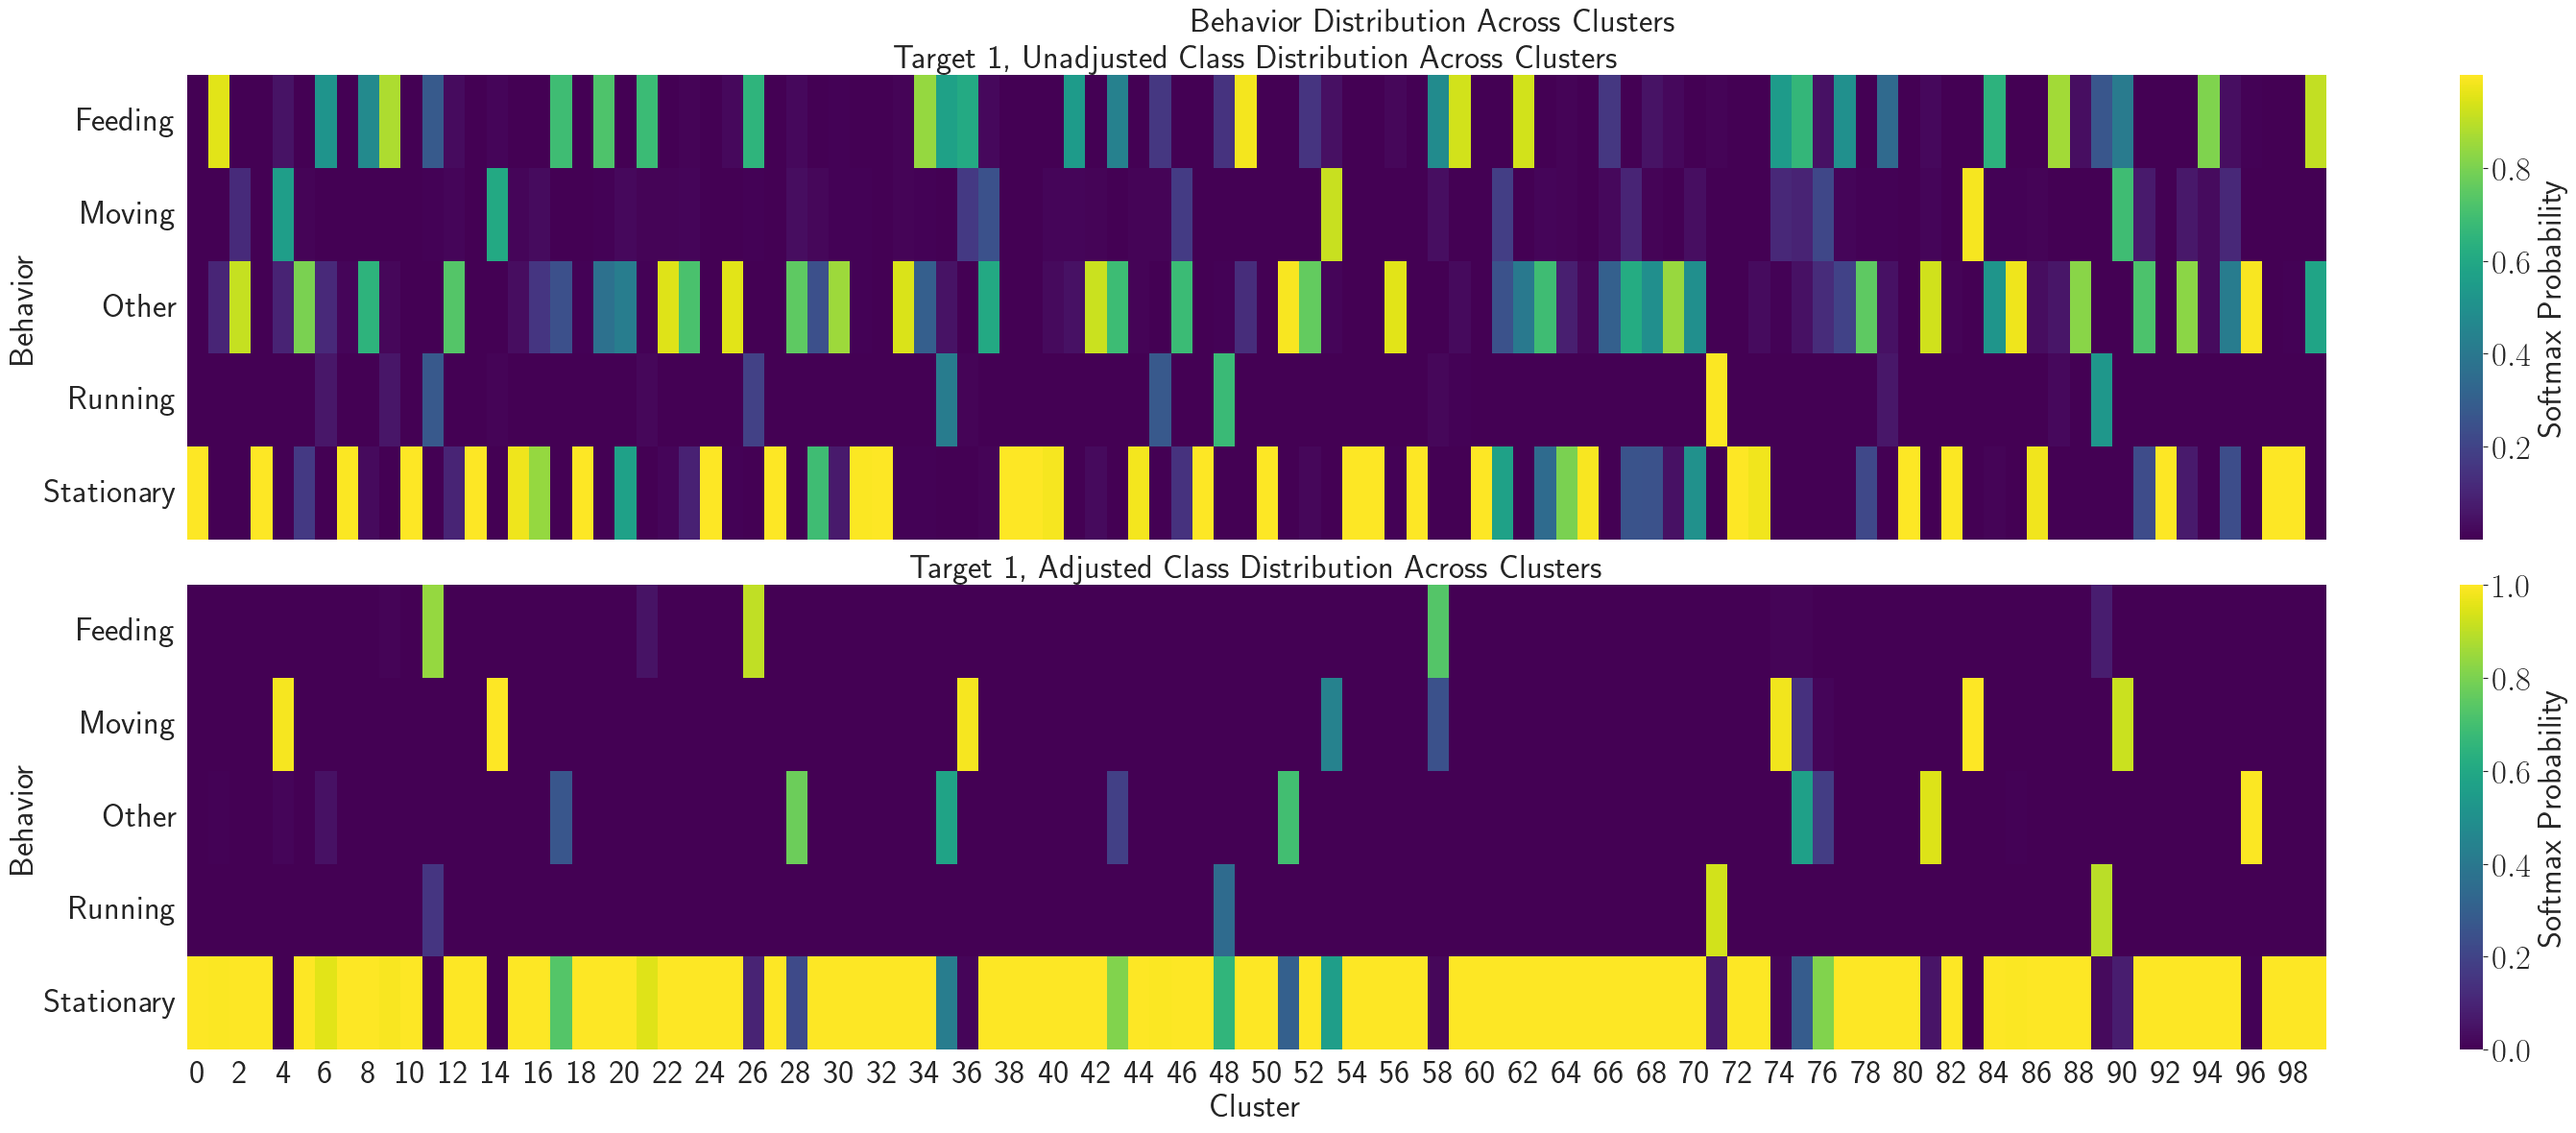

In [89]:
fig, axs = plt.subplots(2, 1, figsize=(30, 12), sharex=True, sharey=True)
sns.heatmap(
    cluster_scores1.T,
    cmap='viridis',
    cbar_kws={'label': 'Softmax Probability'},
    # xticklabels=[str(i) for i in range(cluster_scores.shape[0])],  # clusters on x-axis
    yticklabels=[label_encoder.inverse_transform([i])[0] for i in range(cluster_scores1.shape[1])] ,
    ax=axs[0]
)
sns.heatmap(
    (P1 / cluster_dist1[:, np.newaxis]).T,
    cmap='viridis',
    cbar_kws={'label': 'Softmax Probability'},
    # xticklabels=[str(i) for i in range(cluster_scores.shape[0])],  # clusters on x-axis
    yticklabels=[label_encoder.inverse_transform([i])[0] for i in range(cluster_scores2.shape[1])] ,
    ax=axs[1]
)

axs[1].set_xlabel("Cluster")
axs[0].set_ylabel("Behavior")
axs[1].set_ylabel("Behavior")

axs[0].set_title("Target 1, Unadjusted Class Distribution Across Clusters")
axs[1].set_title("Target 1, Adjusted Class Distribution Across Clusters")
plt.suptitle("Behavior Distribution Across Clusters", fontsize=25)

# Rotate x-axis labels to horizontal
axs[1].tick_params(axis='x', rotation=0)   
axs[1].tick_params(axis='y', rotation=0)   

plt.tight_layout()
plt.show()


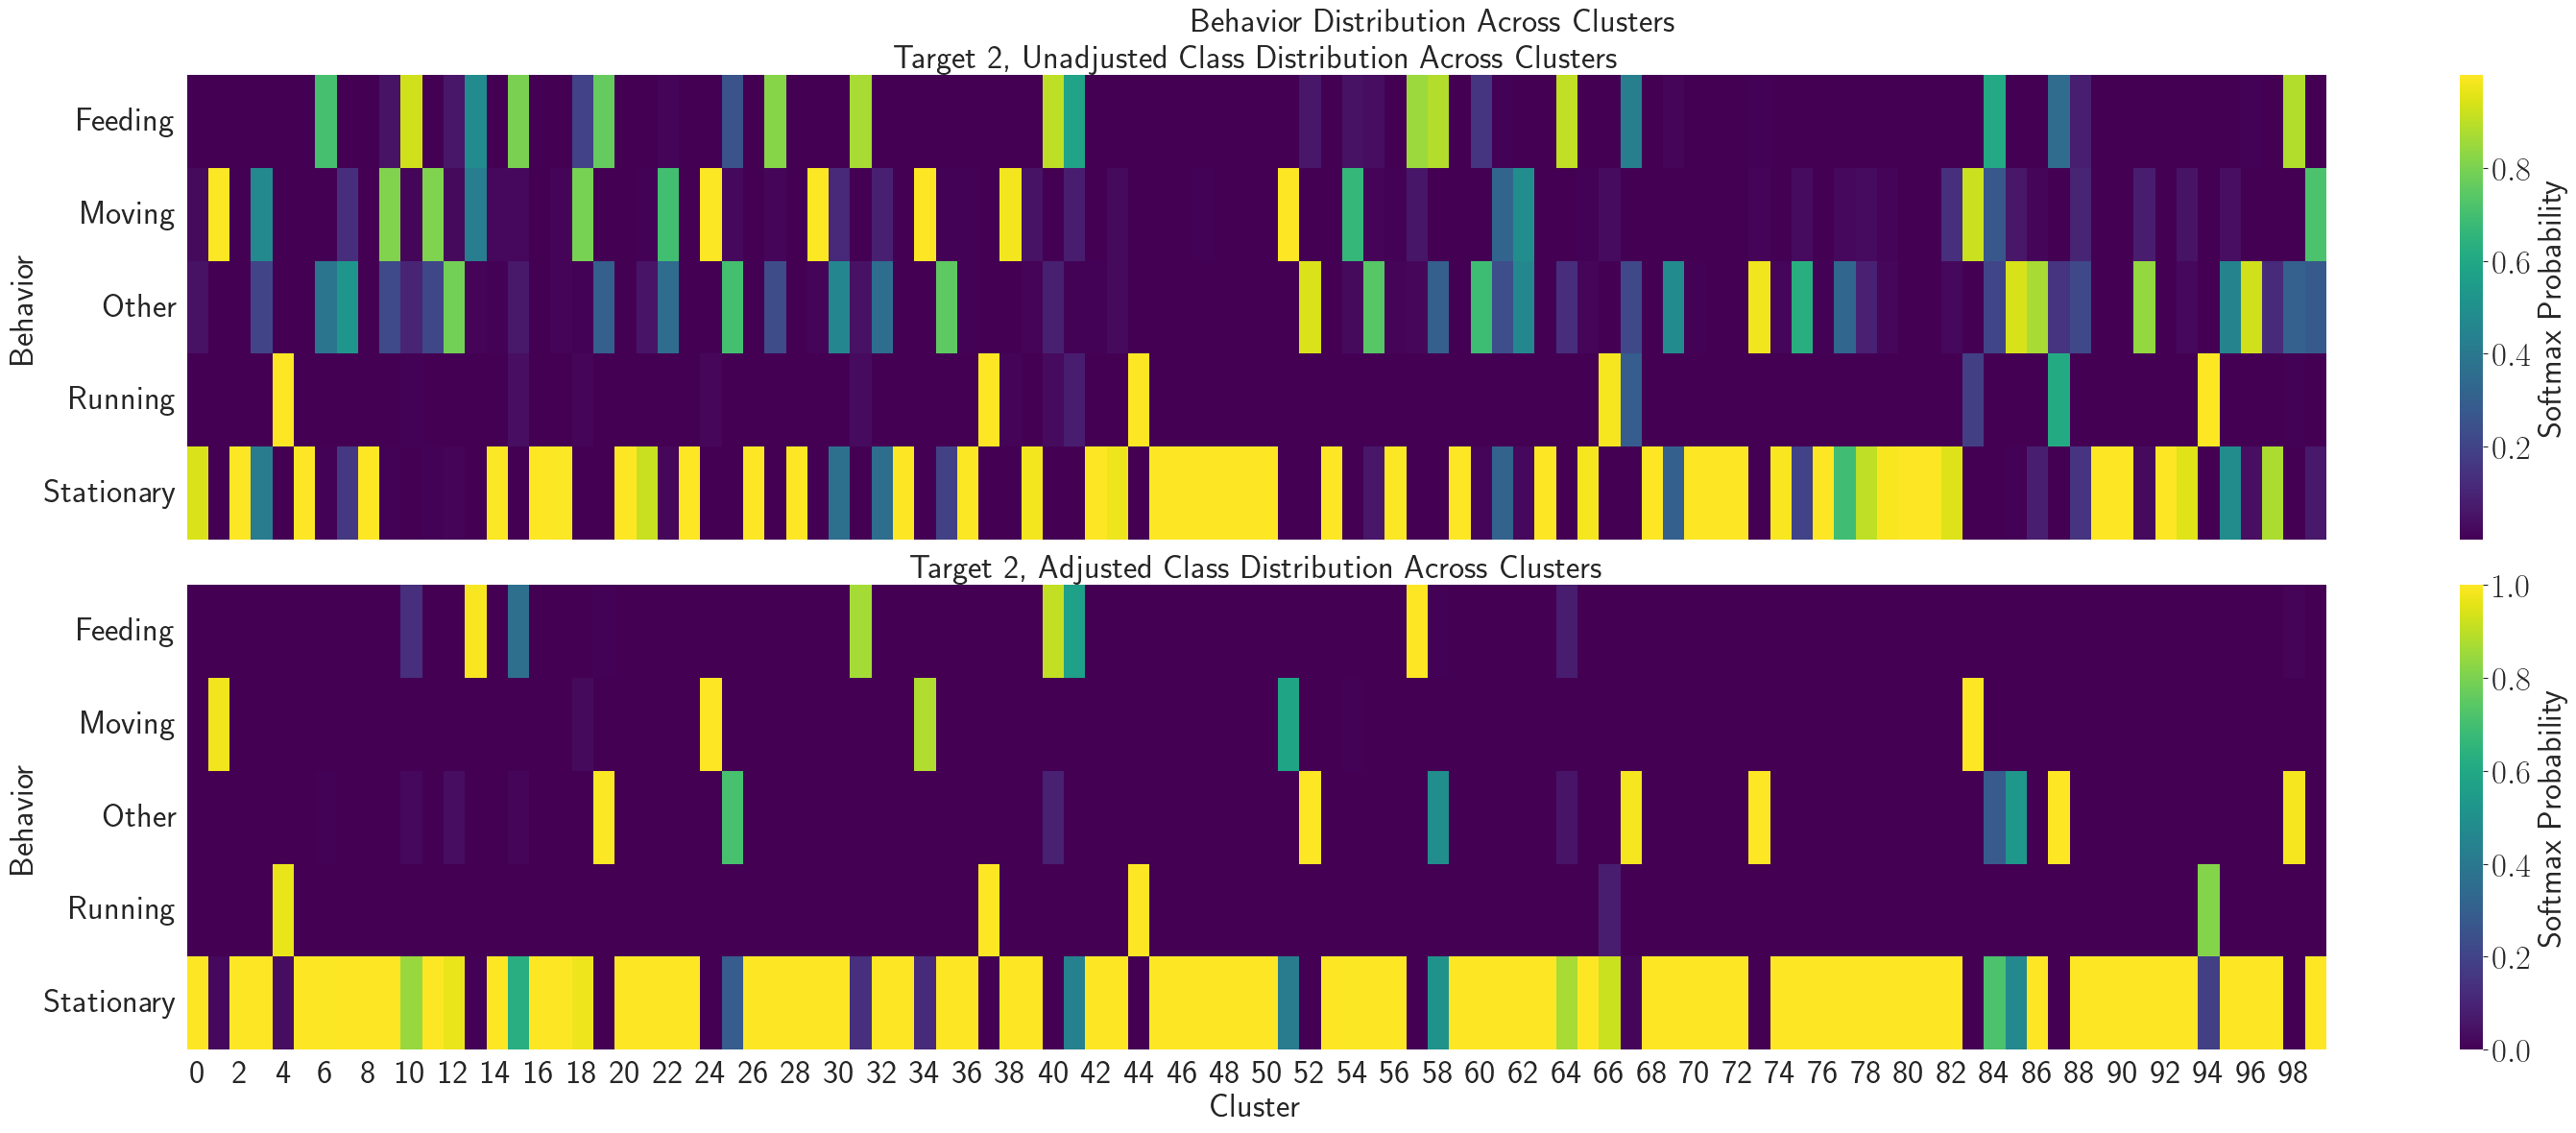

In [90]:
fig, axs = plt.subplots(2, 1, figsize=(30, 12), sharex=True, sharey=True)
sns.heatmap(
    cluster_scores2.T,
    cmap='viridis',
    cbar_kws={'label': 'Softmax Probability'},
    # xticklabels=[str(i) for i in range(cluster_scores.shape[0])],  # clusters on x-axis
    yticklabels=[label_encoder.inverse_transform([i])[0] for i in range(cluster_scores2.shape[1])] ,
    ax=axs[0]
)
sns.heatmap(
    (P2 / cluster_dist2[:, np.newaxis]).T,
    cmap='viridis',
    cbar_kws={'label': 'Softmax Probability'},
    # xticklabels=[str(i) for i in range(cluster_scores.shape[0])],  # clusters on x-axis
    yticklabels=[label_encoder.inverse_transform([i])[0] for i in range(cluster_scores2.shape[1])] ,
    ax=axs[1]
)

axs[1].set_xlabel("Cluster")
axs[0].set_ylabel("Behavior")
axs[1].set_ylabel("Behavior")

axs[0].set_title("Target 2, Unadjusted Class Distribution Across Clusters")
axs[1].set_title("Target 2, Adjusted Class Distribution Across Clusters")
plt.suptitle("Behavior Distribution Across Clusters", fontsize=25)

# Rotate x-axis labels to horizontal
axs[1].tick_params(axis='x', rotation=0)   
axs[1].tick_params(axis='y', rotation=0)   

plt.tight_layout()
plt.show()


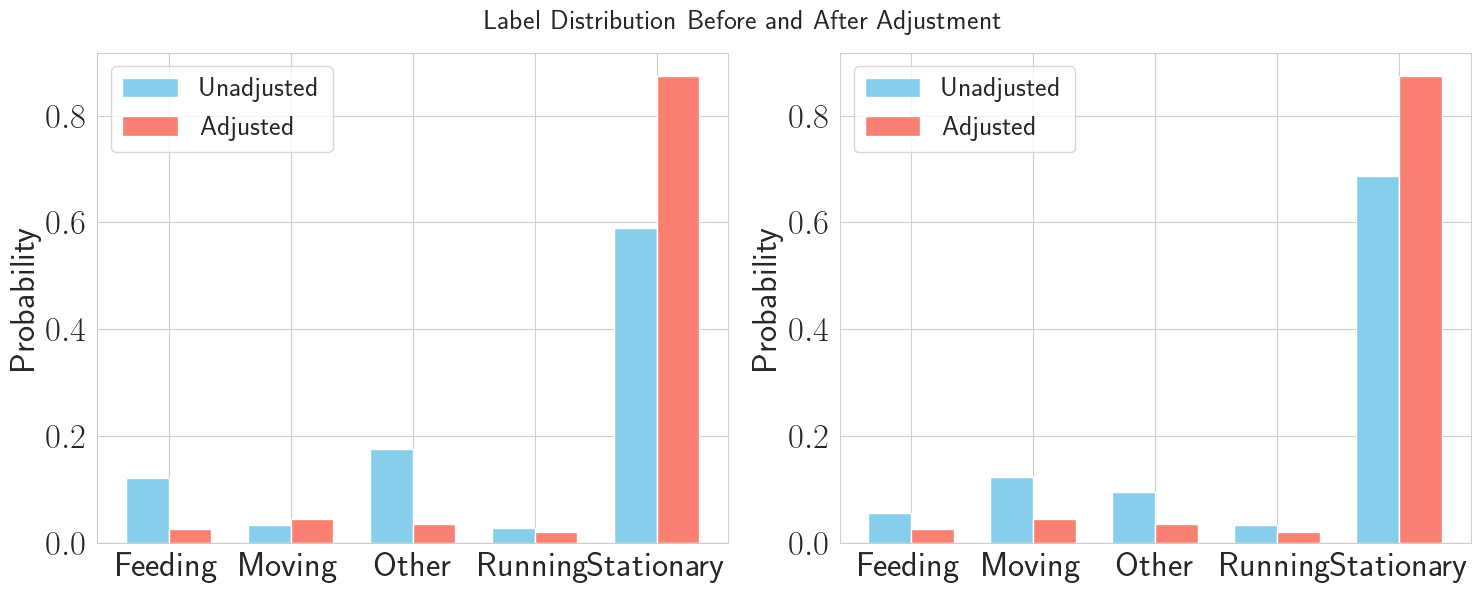

In [91]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
x = np.arange(len(config.SUMMARY_BEHAVIORS))
width = 0.35
rects1 = ax[0].bar(x - width/2, unadjusted_label_dist1, width, label='Unadjusted', color='skyblue')
rects2 = ax[0].bar(x + width/2, adjusted_label_dist1, width, label='Adjusted', color='salmon')

ax[0].set_xticks(x)
ax[0].set_xticklabels(config.SUMMARY_BEHAVIORS)

ax[0].set_ylabel('Probability')
ax[0].legend()

rects1 = ax[1].bar(x - width/2, unadjusted_label_dist2, width, label='Unadjusted', color='skyblue')
rects2 = ax[1].bar(x + width/2, adjusted_label_dist2, width, label='Adjusted', color='salmon')

ax[1].set_xticks(x)
ax[1].set_xticklabels(config.SUMMARY_BEHAVIORS)
ax[1].set_ylabel('Probability')
ax[1].legend()
plt.suptitle("Label Distribution Before and After Adjustment", fontsize=20)
plt.tight_layout()

plt.show()

In [95]:
# make uncalibrated sightings plots
# plot_dir = os.path.join(io.get_sightings_dir(), 'coral', model_name, 'uncalibrated')

# _ = make_sightings_plots_from_model(model=coral_model2, 
#                                    data=transform(torch.tensor(X_targets[1][Vectronics_feature_cols].values, dtype=torch.float32)),
#                                    metadata=X_targets[1],
#                                    matched_sightings=sightings, 
#                                    matched_gps=matched_gps,
#                                    matched_gps_moving=gps_moving, 
#                                    device=device,
#                                    plot_dir=plot_dir)

# make calibrated sightings plots
plot_dir = os.path.join(io.get_sightings_dir(), 'coral', model_name, 'calibrated')

_ = make_sightings_plots_from_clusters(cluster_labels=cluster_labels2,
                                   cluster_scores=adjusted_scores2,
                                   data=transform(torch.tensor(X_targets[1][Vectronics_feature_cols].values, dtype=torch.float32)),
                                   metadata=X_targets[1],
                                   matched_sightings=sightings, 
                                   matched_gps=matched_gps,
                                   gps_clusters=gps_clusters,
                                   matched_gps_moving=gps_moving, 
                                   predictions=predictions2,
                                   plot_dir=plot_dir,
                                   save_predictions=True)

#### Model B

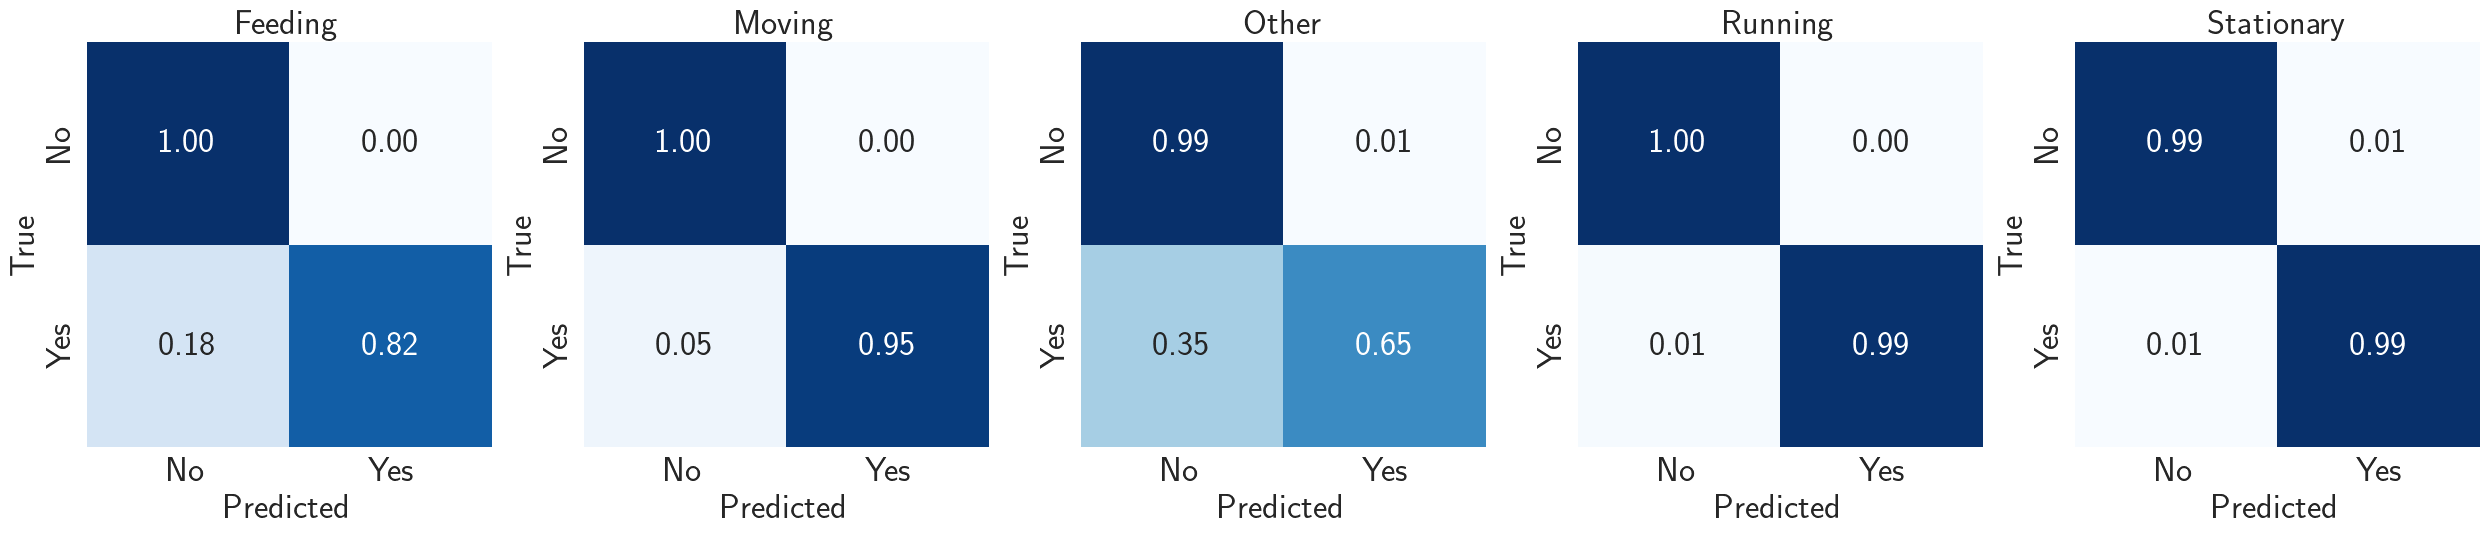

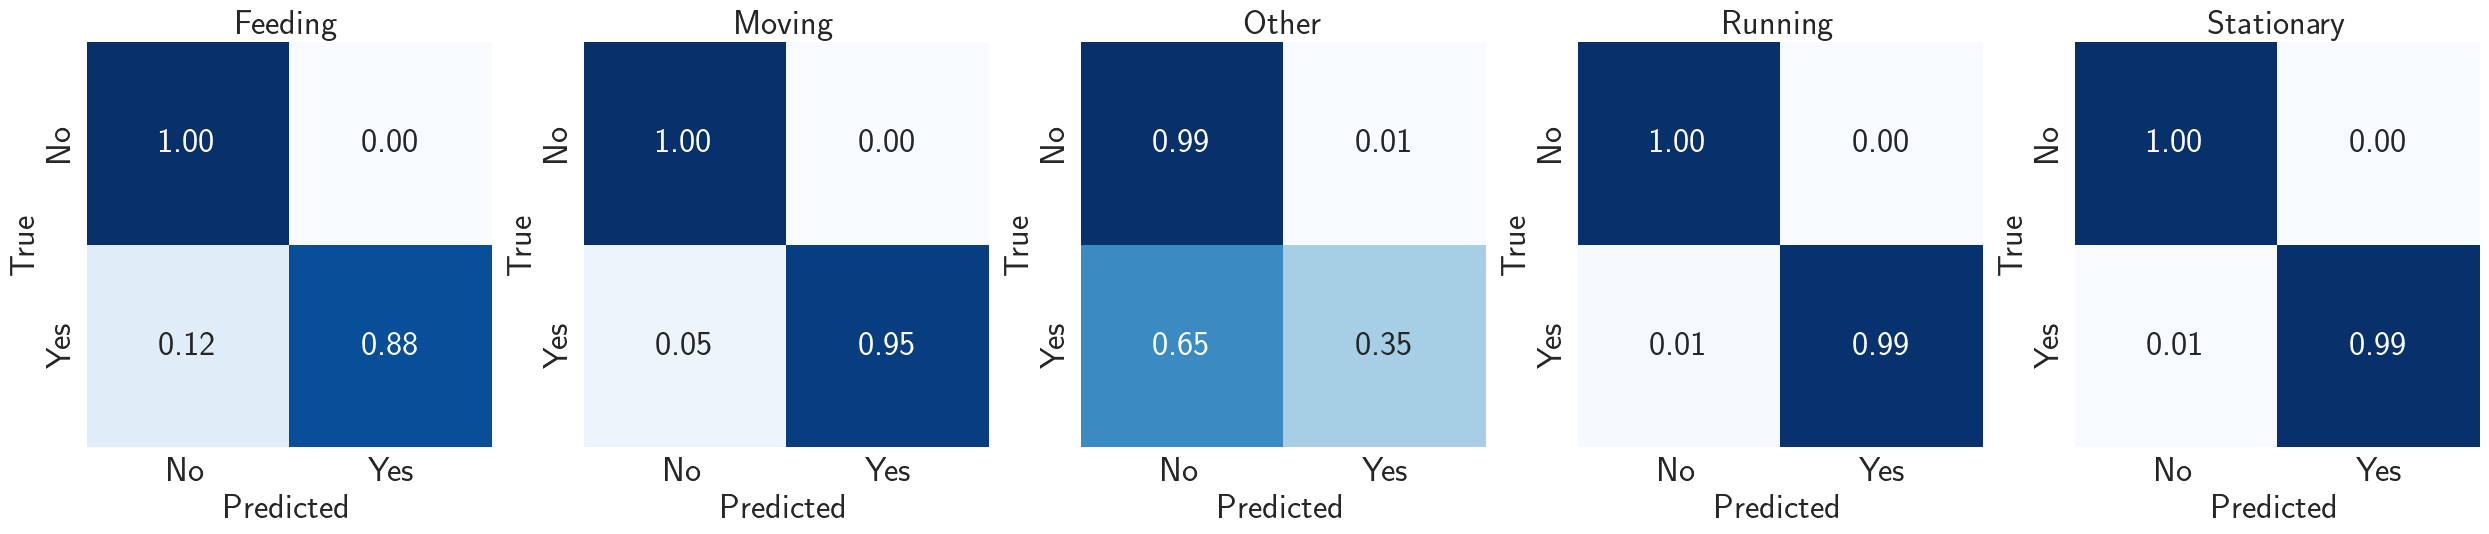

{}

In [164]:
model_name = 'B'
dir1 = os.path.join(io.get_domain_adaptation_results_dir(), "coral", model_name, "target1")
dir2 = os.path.join(io.get_domain_adaptation_results_dir(), "coral", model_name, "target2")

multi_label_predictions(dir1, label_encoder, split='test', plot_confusion=True, return_precision=False)
multi_label_predictions(dir2, label_encoder, split='test', plot_confusion=True, return_precision=False)


In [165]:
for row_idx, dir_path in enumerate([dir1, dir2]):

    # Load results
    results = np.load(os.path.join(dir_path, "test_results.npz"))
    y_true = results["true_classes"]        # shape: (N, C)
    y_pred = results["predictions"]         # shape: (N, C)
    print(np.sum(y_pred[np.where(y_true[:, 2] == 1)[0], :], axis=0))

[ 3  0 11  0  3]
[5 0 6 0 1]


In [ ]:
feat_dim = 128

for i, dir_path in enumerate([dir1, dir2]):
    coral_model = SimpleFeatureNet(X_src.shape[-1], feat_dim, len(np.unique(y_src)))
    coral_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=device))
    coral_model.to(device)

    _, _, _ = evaluate_multilabel_distribution(model=coral_model, 
                                    data=target_loaders[i],
                                    label_encoder=label_encoder,
                                    device=device, 
                                    threshold=0.5)
    
    _, _, _ = evaluate_multilabel_distribution(model=coral_model, 
                                    data=source_loader,
                                    label_encoder=label_encoder,
                                    device=device, 
                                    threshold=0.5)
    
    
    

/tmp/ipykernel_981091/2284528941.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coral_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=


Predicted class % occurrence:
  Feeding: 16.28%
  Moving: 3.26%
  Other: 11.80%
  Running: 1.01%
  Stationary: 58.64%


Evaluating: 100%|██████████| 4296/4296 [00:10<00:00, 421.56it/s]


Predicted class % occurrence:
  Feeding: 7.12%
  Moving: 10.86%
  Other: 6.26%
  Running: 3.75%
  Stationary: 67.78%


In [43]:
plot_dir = os.path.join(io.get_vectronics_eval_dir(), "coral", model_name)

coral_model2 = SimpleFeatureNet(X_src.shape[-1], feat_dim, len(np.unique(y_src)))
coral_model2.load_state_dict(torch.load(os.path.join(dir2, 'model.pt'), map_location=device))
coral_model2.to(device)

make_vectronics_plots_from_model(metadata=X_src_full,
                                features=Vectronics_feature_cols,
                                model=coral_model2,
                                device=device,
                                transform=transform,
                                plot_dir=plot_dir)

/tmp/ipykernel_3902/2598497517.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coral_model2.load_state_dict(torch.load(os.path.join(dir2, 'model.pt'), map_location=devic

In [31]:
coral_model1 = SimpleFeatureNet(X_src.shape[-1], feat_dim, len(np.unique(y_src)))
coral_model1.load_state_dict(torch.load(os.path.join(dir1, 'model.pt'), map_location=device))
coral_model1.to(device)

coral_model2 = SimpleFeatureNet(X_src.shape[-1], feat_dim, len(np.unique(y_src)))
coral_model2.load_state_dict(torch.load(os.path.join(dir2, 'model.pt'), map_location=device))
coral_model2.to(device)

P1, cluster_scores1, unadjusted_label_dist1, adjusted_label_dist1, adjusted_scores1, predictions1 = calibration(cluster_dist1, cluster_centroids1, cluster_labels1, coral_model1, label_dist=label_dist, reg=reg)
P2, cluster_scores2, unadjusted_label_dist2, adjusted_label_dist2, adjusted_scores2, predictions2 = calibration(cluster_dist2, cluster_centroids2, cluster_labels2, coral_model2, label_dist=label_dist, reg=reg)


/tmp/ipykernel_509557/991056575.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coral_model1.load_state_dict(torch.load(os.path.join(dir1, 'model.pt'), map_location=devi

In [ ]:
# make uncalibrated sightings plots
plot_dir = os.path.join(io.get_sightings_dir(), 'coral', model_name, 'uncalibrated')

_ = make_sightings_plots_from_model(model=coral_model2, 
                                   data=transform(torch.tensor(X_targets[1][Vectronics_feature_cols].values, dtype=torch.float32)),
                                   metadata=X_targets[1],
                                   matched_sightings=sightings, 
                                   matched_gps=matched_gps,
                                   matched_gps_moving=gps_moving, 
                                   device=device,
                                   plot_dir=plot_dir)

# make calibrated sightings plots
plot_dir = os.path.join(io.get_sightings_dir(), 'coral', model_name, 'calibrated')

_ = make_sightings_plots_from_clusters(cluster_labels=cluster_labels2,
                                   cluster_scores=adjusted_scores2,
                                   data=transform(torch.tensor(X_targets[1][Vectronics_feature_cols].values, dtype=torch.float32)),
                                   metadata=X_targets[1],
                                   matched_sightings=sightings, 
                                   matched_gps=matched_gps,
                                   gps_clusters=gps_clusters,
                                   matched_gps_moving=gps_moving, 
                                   predictions=predictions2,
                                   plot_dir=plot_dir,
                                   save_predictions=True)

Evaluating: 100%|██████████| 2/2 [00:00<00:00, 182.06it/s]3,  3.30s/it]


#### Model C

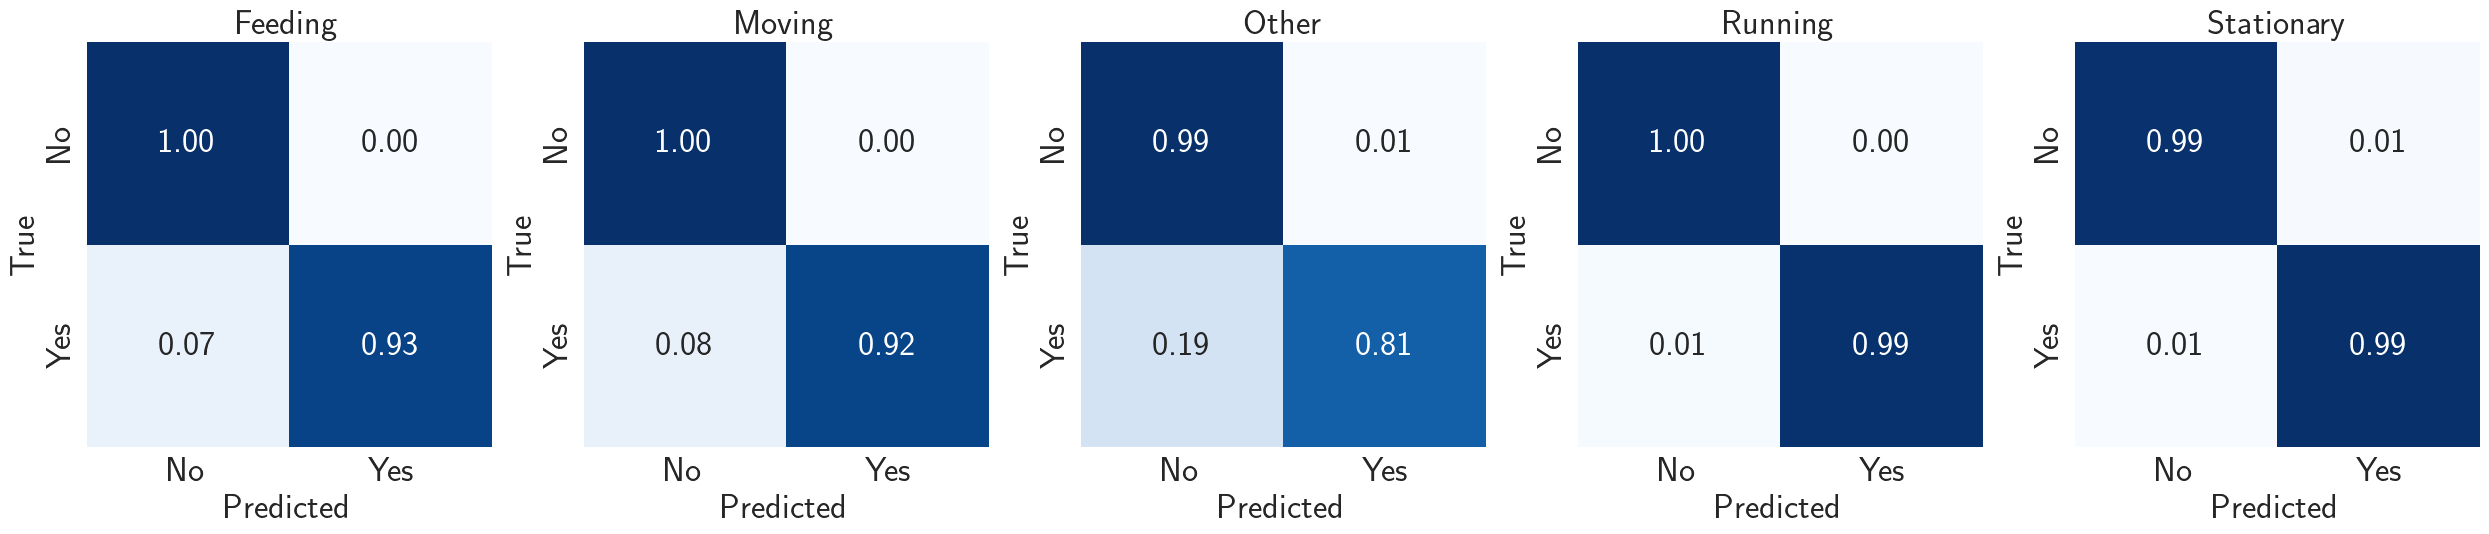

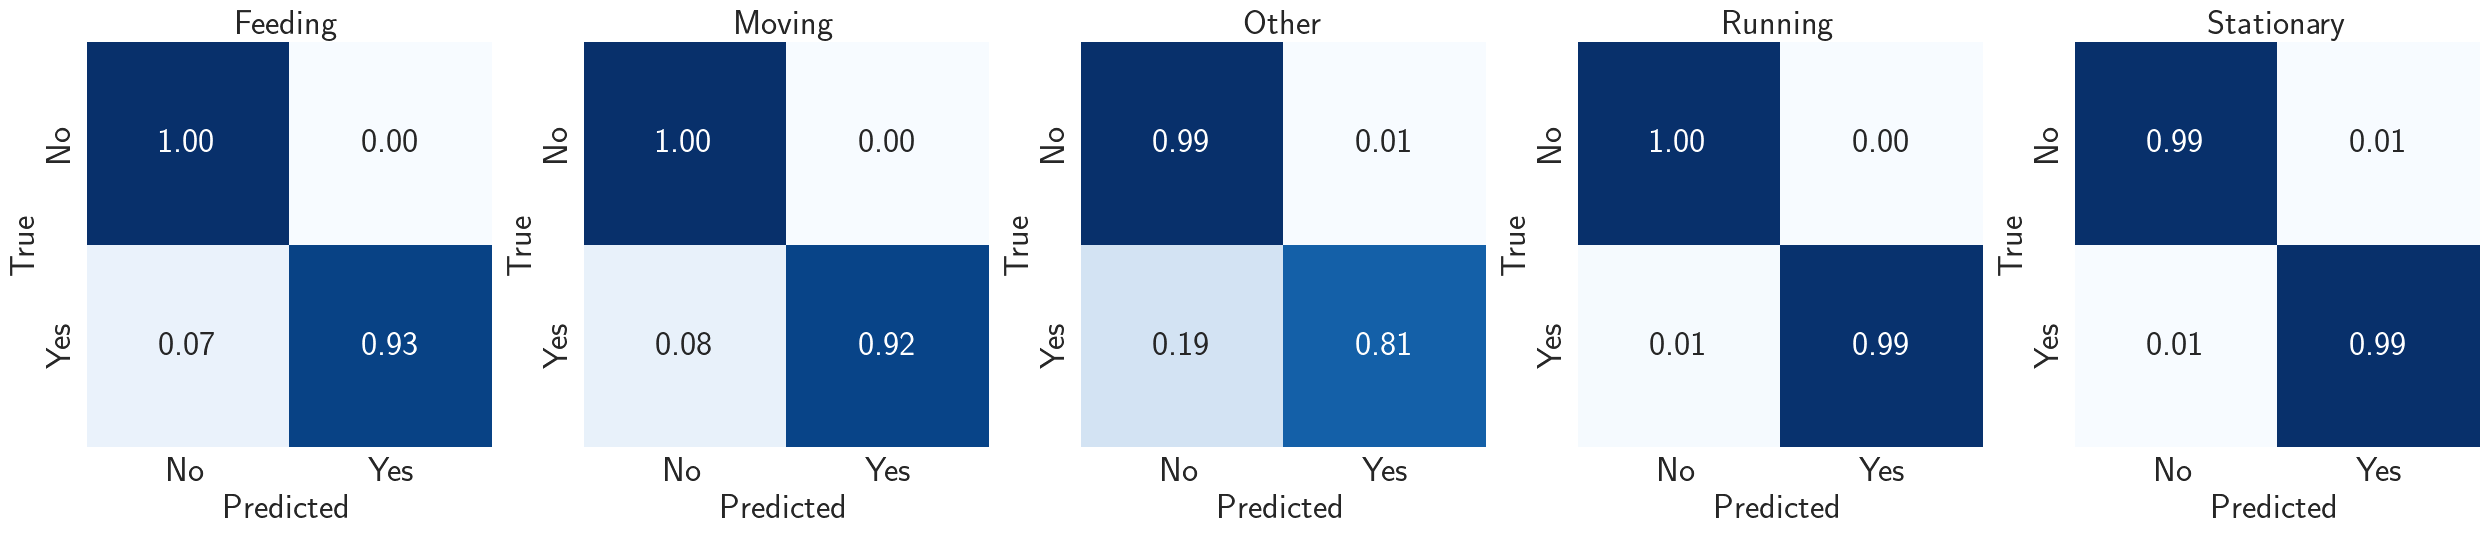

{}

In [166]:
model_name = 'C'
dir1 = os.path.join(io.get_domain_adaptation_results_dir(), "coral", model_name, "target1")
dir2 = os.path.join(io.get_domain_adaptation_results_dir(), "coral", model_name, "target2")

multi_label_predictions(dir1, label_encoder, split='test', plot_confusion=True, return_precision=False)
multi_label_predictions(dir2, label_encoder, split='test', plot_confusion=True, return_precision=False)



In [167]:
for row_idx, dir_path in enumerate([dir1, dir2]):

    # Load results
    results = np.load(os.path.join(dir_path, "test_results.npz"))
    y_true = results["true_classes"]        # shape: (N, C)
    y_pred = results["predictions"]         # shape: (N, C)
    print(np.sum(y_pred[np.where(y_true[:, 2] == 1)[0], :], axis=0))

[ 7  2 67  0  5]
[ 8  1 67  0  4]


In [168]:
feat_dim = 128

for i, dir_path in enumerate([dir1, dir2]):
    coral_model = SimpleFeatureNet(X_src.shape[-1], feat_dim, len(np.unique(y_src)))
    coral_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=device))
    coral_model.to(device)

    _, _, _ = evaluate_multilabel_distribution(model=coral_model, 
                                    data=target_loaders[i],
                                    label_encoder=label_encoder,
                                    device=device, 
                                    threshold=0.5)
    _, _, _ = evaluate_multilabel_distribution(model=coral_model, 
                                    data=source_loader,
                                    label_encoder=label_encoder,
                                    device=device, 
                                    threshold=0.5)
    

/tmp/ipykernel_596177/505989692.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coral_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=d


Predicted class % occurrence:
  Feeding: 11.36%
  Moving: 3.32%
  Other: 16.39%
  Running: 2.94%
  Stationary: 59.36%

Predicted class % occurrence:
  Feeding: 0.64%
  Moving: 7.82%
  Other: 2.90%
  Running: 1.60%
  Stationary: 85.94%


/tmp/ipykernel_596177/505989692.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coral_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=d


Predicted class % occurrence:
  Feeding: 4.69%
  Moving: 11.77%
  Other: 7.84%
  Running: 4.06%
  Stationary: 68.93%

Predicted class % occurrence:
  Feeding: 0.63%
  Moving: 8.39%
  Other: 2.83%
  Running: 1.61%
  Stationary: 85.32%


In [ ]:
plot_dir = os.path.join(io.get_vectronics_eval_dir(), "coral", model_name)

coral_model2 = SimpleFeatureNet(X_src.shape[-1], feat_dim, len(np.unique(y_src)))
coral_model2.load_state_dict(torch.load(os.path.join(dir2, 'model.pt'), map_location=device))
coral_model2.to(device)

make_vectronics_plots_from_model(metadata=X_src_full,
                                features=Vectronics_feature_cols,
                                model=coral_model2,
                                device=device,
                                transform=transform,
                                plot_dir=plot_dir)

In [169]:
coral_model1 = SimpleFeatureNet(X_src.shape[-1], feat_dim, len(np.unique(y_src)))
coral_model1.load_state_dict(torch.load(os.path.join(dir1, 'model.pt'), map_location=device))
coral_model1.to(device)

coral_model2 = SimpleFeatureNet(X_src.shape[-1], feat_dim, len(np.unique(y_src)))
coral_model2.load_state_dict(torch.load(os.path.join(dir2, 'model.pt'), map_location=device))
coral_model2.to(device)

P1, cluster_scores1, unadjusted_label_dist1, adjusted_label_dist1, adjusted_scores1, predictions1 = calibration(cluster_dist1, cluster_centroids1, cluster_labels1, coral_model1, label_dist=label_dist, reg=reg)
P2, cluster_scores2, unadjusted_label_dist2, adjusted_label_dist2, adjusted_scores2, predictions2 = calibration(cluster_dist2, cluster_centroids2, cluster_labels2, coral_model2, label_dist=label_dist, reg=reg)


/tmp/ipykernel_596177/991056575.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coral_model1.load_state_dict(torch.load(os.path.join(dir1, 'model.pt'), map_location=devi

In [170]:
# make uncalibrated sightings plots
plot_dir = os.path.join(io.get_sightings_dir(), 'coral', model_name, 'uncalibrated')

_ = make_sightings_plots_from_model(model=coral_model2, 
                                   data=transform(torch.tensor(X_targets[1][Vectronics_feature_cols].values, dtype=torch.float32)),
                                   metadata=X_targets[1],
                                   matched_sightings=sightings, 
                                   matched_gps=matched_gps,
                                   matched_gps_moving=gps_moving, 
                                   device=device,
                                   plot_dir=plot_dir)

# make calibrated sightings plots
plot_dir = os.path.join(io.get_sightings_dir(), 'coral', model_name, 'calibrated')

_ = make_sightings_plots_from_clusters(cluster_labels=cluster_labels2,
                                   cluster_scores=adjusted_scores2,
                                   data=transform(torch.tensor(X_targets[1][Vectronics_feature_cols].values, dtype=torch.float32)),
                                   metadata=X_targets[1],
                                   matched_sightings=sightings, 
                                   matched_gps=matched_gps,
                                   gps_clusters=gps_clusters,
                                   matched_gps_moving=gps_moving, 
                                   predictions=predictions2,
                                   plot_dir=plot_dir,
                                   save_predictions=True)

Processing animal-days:   0%|          | 0/20 [00:00<?, ?it/s]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from tqdm import tqdm
from matplotlib.patches import Circle

R = 6371008.8  # Earth radius in meters
radius_m = 100
radius_deg_lat = radius_m / 111320

In [2]:

def run_dbscan(gps_day):
    coords = gps_day[['latitude', 'longitude']].values
    epsilon = 0.1 / 6371.0088  # 100 m in radians
    db = DBSCAN(eps=epsilon, min_samples=5, metric='haversine')
    gps_day['cluster'] = db.fit_predict(np.radians(coords))
    return gps_day

def circle_radius_deg(lon_lat):
    lat = lon_lat[0]
    return radius_m / (111320 * np.cos(np.radians(lat)))

def plot_cluster_visuals(cluster_points):
    """Plot centroid + 100m circle."""
    centroid_lat = cluster_points['latitude'].mean()
    centroid_lon = cluster_points['longitude'].mean()
    r = circle_radius_deg((centroid_lat, centroid_lon))

    plt.scatter(centroid_lon, centroid_lat, color='black',
                s=50, marker='x', linewidths=1, zorder=5)
    circle = Circle((centroid_lon, centroid_lat), r,
                    edgecolor='black', facecolor='none',
                    linestyle='--', linewidth=0.7, alpha=0.8)
    plt.gca().add_patch(circle)

def plot_cluster_points(cluster_points, color):
    """Grey shapes: circles <450s, squares >=450s."""
    round_pts = cluster_points[cluster_points['time_diff [s]'] < 450]
    square_pts = cluster_points[cluster_points['time_diff [s]'] >= 450]

    if not round_pts.empty:
        plt.scatter(round_pts['longitude'], round_pts['latitude'],
                    color=color, marker='o', s=40, alpha=0.9)
    if not square_pts.empty:
        plt.scatter(square_pts['longitude'], square_pts['latitude'],
                    color=color, marker='s', s=40, alpha=0.9)


In [127]:
all_cluster_points = []
grouped_sightings = sightings.groupby(['animal_id', 'UTC date [yyyy-mm-dd]'])

plot_dir = os.path.join(io.get_sightings_dir(), 'gps_clusters')
os.makedirs(plot_dir, exist_ok=True)

for (animal_id, date), _ in tqdm(grouped_sightings, desc="Processing animal-days"):

    gps_day = matched_gps[
        (matched_gps['animal_id'] == animal_id) &
        (matched_gps['UTC date [yyyy-mm-dd]'] == date)
    ].copy()

    if gps_day.empty:
        continue

    gps_day = gps_day.sort_values(by='UTC time [yyyy-mm-dd HH:MM:SS]')
    gps_day = run_dbscan(gps_day)

    valid_cluster_points = gps_day[gps_day['cluster'] != -1]
    all_cluster_points.append(valid_cluster_points)


    unique_labels = np.sort(np.unique(gps_day['cluster']))

    valid_cluster_ids = np.sort(valid_cluster_points['cluster'].unique())
    color_list = [config.COLOR_LIST[i % len(config.COLOR_LIST)] for i in range(len(valid_cluster_ids))]
    cluster_colors = {cid: color_list[i] for i, cid in enumerate(valid_cluster_ids)}
    print(len(valid_cluster_ids))


    plt.figure(figsize=(10, 6))
    plt.plot(gps_day['longitude'], gps_day['latitude'],
             linestyle='--', linewidth=1, alpha=0.6, color='black')

    cluster_handles = []
    cluster_labels = []

    for idx, label in enumerate(unique_labels):

        cluster_points = gps_day[gps_day['cluster'] == label]
        color = cluster_colors[label] if label != -1 else 'gray'

        # ----- Summary output table -----
        if label != -1:
            valid_points = gps_day[gps_day['cluster'] != -1]


        # ----- Plot centroid + 100m circle -----
        if label != -1:
            plot_cluster_visuals(cluster_points, color)

        # ----- Legend entry -----
        handle = plt.scatter([], [], color=color, s=60)
        cluster_handles.append(handle)
        cluster_labels.append(
            f"Cluster {label+1} ({len(cluster_points)})" if label != -1 else "Outliers"
        )

        # ----- Plot actual GPS points -----
        plot_cluster_points(cluster_points, color)

    # Marker legend
    marker_handles = [
        plt.scatter([], [], color='gray', marker='o', s=60),
        plt.scatter([], [], color='gray', marker='s', s=60)
    ]
    marker_labels = [f"$<$ 450 s", f"$>$ 450 s"]

    legend1 = plt.legend(cluster_handles, cluster_labels,
                        loc='upper left', bbox_to_anchor=(1.0, 1.0))
    legend2 = plt.legend(marker_handles, marker_labels,
                        loc='upper left', bbox_to_anchor=(1.0, 0.25))
    plt.gca().add_artist(legend1)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'{animal_id} | {date}')
    plt.grid(True)
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.savefig(os.path.join(plot_dir, f"{animal_id}_{date}.png"))
    plt.close()


# -------- Final Summary DataFrame -------- #

cluster_points_df = pd.concat(all_cluster_points, ignore_index=True)
cluster_points_df = cluster_points_df[
    ['UTC time [yyyy-mm-dd HH:MM:SS]',
     'latitude',
     'longitude',
     'timestamp_prev [yyyy-mm-dd HH:MM:SS]',
     'time_diff [s]',
     'distance [m]',
     'collar_number',
     'animal_id',
     'UTC date [yyyy-mm-dd]',
     'cluster']
]
cluster_points_df.to_csv(os.path.join(io.get_data_path(), 'GPS_clusters.csv'))

Processing animal-days:   0%|          | 0/20 [00:00<?, ?it/s]

6


Processing animal-days:   5%|▌         | 1/20 [00:00<00:09,  2.06it/s]

6


Processing animal-days:  10%|█         | 2/20 [00:00<00:08,  2.09it/s]

3


Processing animal-days:  15%|█▌        | 3/20 [00:01<00:07,  2.27it/s]

5


Processing animal-days:  20%|██        | 4/20 [00:01<00:07,  2.28it/s]

4


Processing animal-days:  25%|██▌       | 5/20 [00:02<00:06,  2.32it/s]

5


Processing animal-days:  30%|███       | 6/20 [00:02<00:06,  2.30it/s]

6


Processing animal-days:  35%|███▌      | 7/20 [00:03<00:05,  2.23it/s]

5


Processing animal-days:  40%|████      | 8/20 [00:03<00:05,  2.27it/s]

3


Processing animal-days:  45%|████▌     | 9/20 [00:03<00:04,  2.37it/s]

2


Processing animal-days:  50%|█████     | 10/20 [00:04<00:03,  2.52it/s]

5


Processing animal-days:  55%|█████▌    | 11/20 [00:04<00:03,  2.46it/s]

4


Processing animal-days:  60%|██████    | 12/20 [00:05<00:03,  2.45it/s]

5


Processing animal-days:  65%|██████▌   | 13/20 [00:05<00:02,  2.37it/s]

7


Processing animal-days:  70%|███████   | 14/20 [00:06<00:02,  2.20it/s]

6


Processing animal-days:  75%|███████▌  | 15/20 [00:06<00:02,  2.18it/s]

8


Processing animal-days:  80%|████████  | 16/20 [00:07<00:01,  2.09it/s]

4


Processing animal-days:  85%|████████▌ | 17/20 [00:07<00:01,  2.18it/s]

7


Processing animal-days:  90%|█████████ | 18/20 [00:07<00:00,  2.16it/s]

3


Processing animal-days:  95%|█████████▌| 19/20 [00:08<00:00,  2.23it/s]

5


Processing animal-days: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s]


## Method 2: DANN

#### Model A

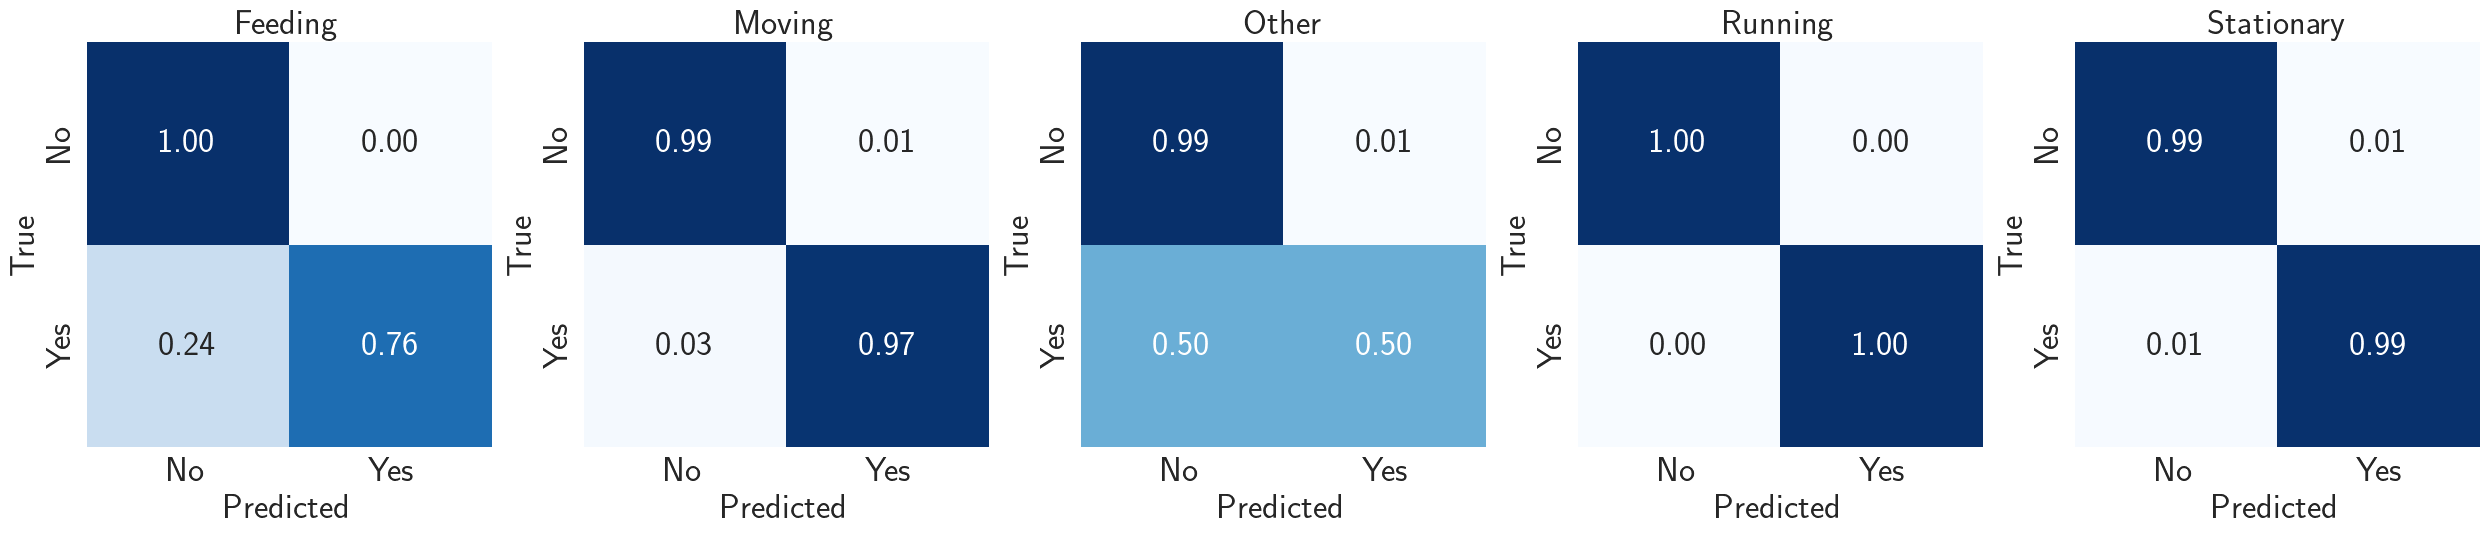

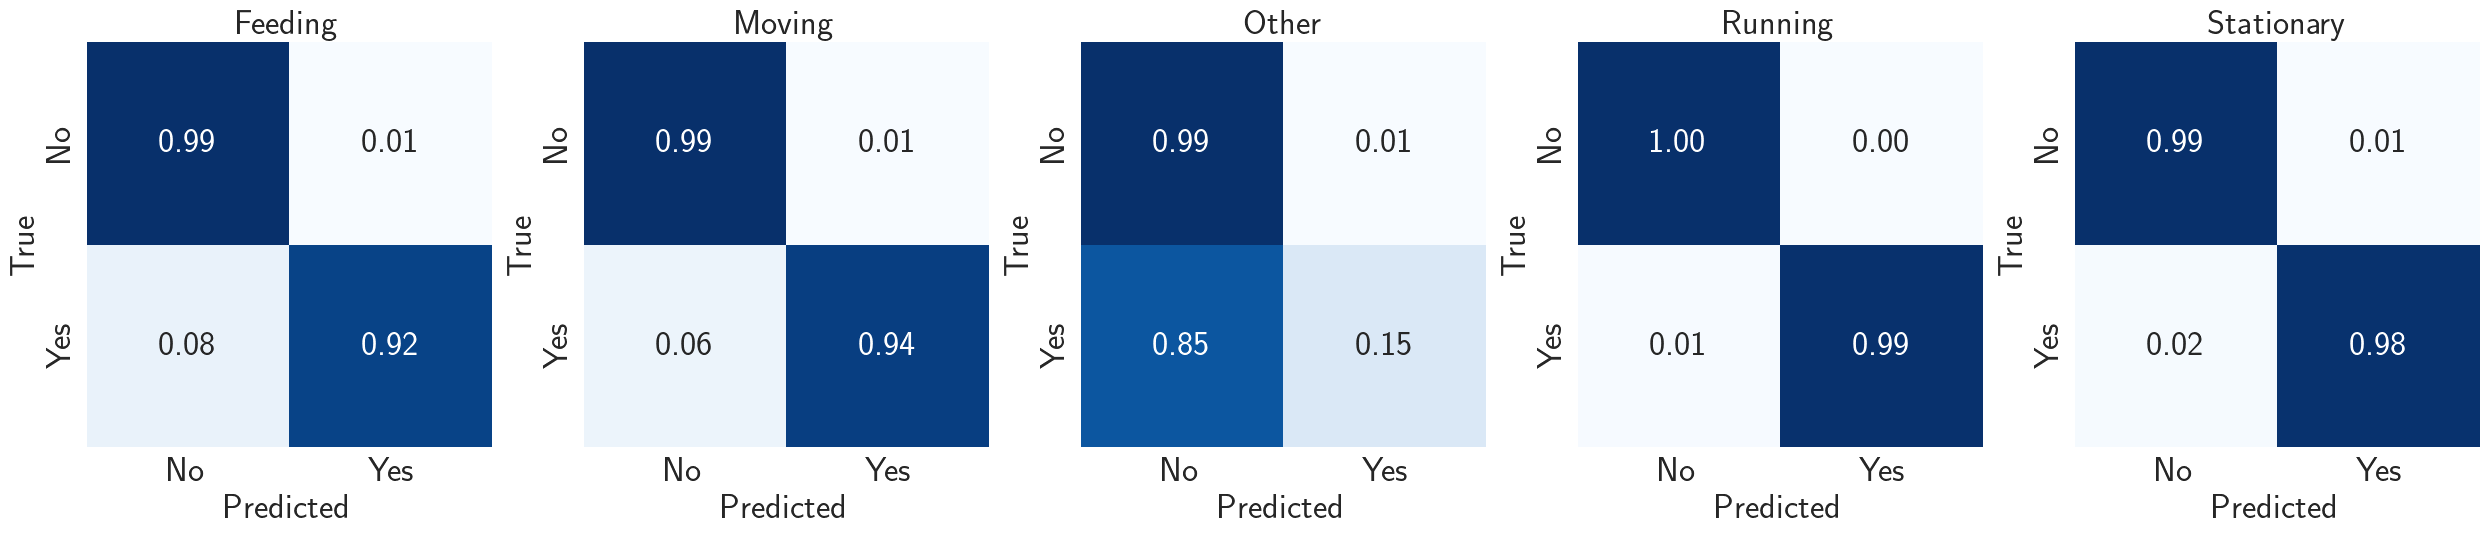

{}

In [144]:
model_name = 'A'
dir1 = os.path.join(io.get_domain_adaptation_results_dir(), "dann", model_name, "target1")
dir2 = os.path.join(io.get_domain_adaptation_results_dir(), "dann", model_name, "target2")

multi_label_predictions(dir1, label_encoder, split='test', plot_confusion=True, return_precision=False)
multi_label_predictions(dir2, label_encoder, split='test', plot_confusion=True, return_precision=False)


In [145]:
for row_idx, dir_path in enumerate([dir1]):

    # Load results
    results = np.load(os.path.join(dir_path, "test_results.npz"))
    y_true = results["true_classes"]        # shape: (N, C)
    y_pred = results["predictions"]         # shape: (N, C)
    print(np.sum(y_pred[np.where(y_true[:, 2] == 1)[0], :], axis=0))

[ 5  5 13  0  3]


In [146]:
hidden_dim = 128

for i, dir_path in enumerate([dir1, dir2]):

    feat = FeatureExtractor(in_dim=X_src.shape[-1], hidden_dim=hidden_dim).to(device)
    clf = LabelClassifier(in_dim=hidden_dim, n_classes=len(np.unique(y_src))).to(device)
    dom = DomainClassifier(in_dim=hidden_dim).to(device)
    dann_model = DANNModel(feat, clf, dom).to(device)
    dann_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=device))
    dann_model.to(device)

    
    _, _, _ = evaluate_multilabel_distribution(model=dann_model, 
                                    data=target_loaders[i],
                                    label_encoder=label_encoder,
                                    device=device, 
                                    threshold=0.5)
    
    

/tmp/ipykernel_981091/2568337154.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dann_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=d

Evaluating: 100%|██████████| 1149/1149 [00:02<00:00, 494.06it/s]
/tmp/ipykernel_981091/2568337154.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dann_model.load_state_d


Predicted class % occurrence:
  Feeding: 18.27%
  Moving: 6.69%
  Other: 9.12%
  Running: 6.45%
  Stationary: 56.48%


Evaluating: 100%|██████████| 4296/4296 [00:07<00:00, 574.82it/s]


Predicted class % occurrence:
  Feeding: 6.67%
  Moving: 12.79%
  Other: 7.51%
  Running: 5.60%
  Stationary: 65.25%


In [147]:
feat = FeatureExtractor(in_dim=X_src.shape[-1], hidden_dim=hidden_dim).to(device)
clf = LabelClassifier(in_dim=hidden_dim, n_classes=len(np.unique(y_src))).to(device)
dom = DomainClassifier(in_dim=hidden_dim).to(device)
dann_model2 = DANNModel(feat, clf, dom).to(device)
dann_model2.load_state_dict(torch.load(os.path.join(dir2, 'model.pt'), map_location=device))
dann_model2.to(device)

P2, cluster_scores2, unadjusted_label_dist2, adjusted_label_dist2, adjusted_scores2, predictions2 = calibration(cluster_dist2, cluster_centroids2, cluster_labels2, dann_model2, label_dist=label_dist, reg=0.1)

_ = make_sightings_plots_from_clusters(cluster_labels=cluster_labels2,
                                   cluster_scores=adjusted_scores2,
                                   data=transform(torch.tensor(X_targets[1][Vectronics_feature_cols].values, dtype=torch.float32)),
                                   metadata=X_targets[1],
                                   matched_sightings=sightings, 
                                   matched_gps=matched_gps,
                                   gps_clusters=gps_clusters,
                                   matched_gps_moving=gps_moving, 
                                   predictions=predictions2,
                                   plot_dir=os.path.join(io.get_sightings_dir(), "dann", model_name, 'calibrated'))

/tmp/ipykernel_981091/269704769.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dann_model2.load_state_dict(torch.load(os.path.join(dir2, 'model.pt'), map_location=devic

No. of GPS moving: 42
No. of GPS clusters: 54


Processing animal-days:   5%|▌         | 1/20 [00:03<01:12,  3.84s/it]

No. of GPS moving: 72
No. of GPS clusters: 51


Processing animal-days:  10%|█         | 2/20 [00:07<01:10,  3.94s/it]

No. of GPS moving: 41
No. of GPS clusters: 79


Processing animal-days:  15%|█▌        | 3/20 [00:11<01:07,  3.97s/it]

No. of GPS moving: 23
No. of GPS clusters: 66


Processing animal-days:  20%|██        | 4/20 [00:17<01:11,  4.45s/it]

No. of GPS moving: 51
No. of GPS clusters: 40


Processing animal-days:  25%|██▌       | 5/20 [00:21<01:04,  4.28s/it]

No. of GPS moving: 52
No. of GPS clusters: 56


Processing animal-days:  30%|███       | 6/20 [00:24<00:56,  4.05s/it]

No. of GPS moving: 61
No. of GPS clusters: 80


Processing animal-days:  35%|███▌      | 7/20 [00:28<00:52,  4.00s/it]

No. of GPS moving: 67
No. of GPS clusters: 50


Processing animal-days:  40%|████      | 8/20 [00:32<00:46,  3.89s/it]

No. of GPS moving: 59
No. of GPS clusters: 49


Processing animal-days:  45%|████▌     | 9/20 [00:35<00:41,  3.74s/it]

No. of GPS moving: 35
No. of GPS clusters: 61


Processing animal-days:  50%|█████     | 10/20 [00:39<00:38,  3.80s/it]

No. of GPS moving: 61
No. of GPS clusters: 79


Processing animal-days:  55%|█████▌    | 11/20 [00:43<00:35,  3.99s/it]

No. of GPS moving: 58
No. of GPS clusters: 99


Processing animal-days:  60%|██████    | 12/20 [00:47<00:31,  3.99s/it]

No. of GPS moving: 45
No. of GPS clusters: 88


Processing animal-days:  65%|██████▌   | 13/20 [00:51<00:27,  3.92s/it]

No. of GPS moving: 68
No. of GPS clusters: 85


Processing animal-days:  70%|███████   | 14/20 [00:55<00:23,  3.90s/it]

No. of GPS moving: 76
No. of GPS clusters: 67


Processing animal-days:  75%|███████▌  | 15/20 [00:59<00:19,  3.91s/it]

No. of GPS moving: 50
No. of GPS clusters: 91


Processing animal-days:  80%|████████  | 16/20 [01:03<00:15,  3.92s/it]

No. of GPS moving: 63
No. of GPS clusters: 53


Processing animal-days:  85%|████████▌ | 17/20 [01:07<00:11,  3.84s/it]

No. of GPS moving: 41
No. of GPS clusters: 84


Processing animal-days:  90%|█████████ | 18/20 [01:10<00:07,  3.75s/it]

No. of GPS moving: 48
No. of GPS clusters: 132


Processing animal-days:  95%|█████████▌| 19/20 [01:15<00:03,  3.99s/it]

No. of GPS moving: 65
No. of GPS clusters: 97


Processing animal-days: 100%|██████████| 20/20 [01:19<00:00,  3.97s/it]


#### Model B

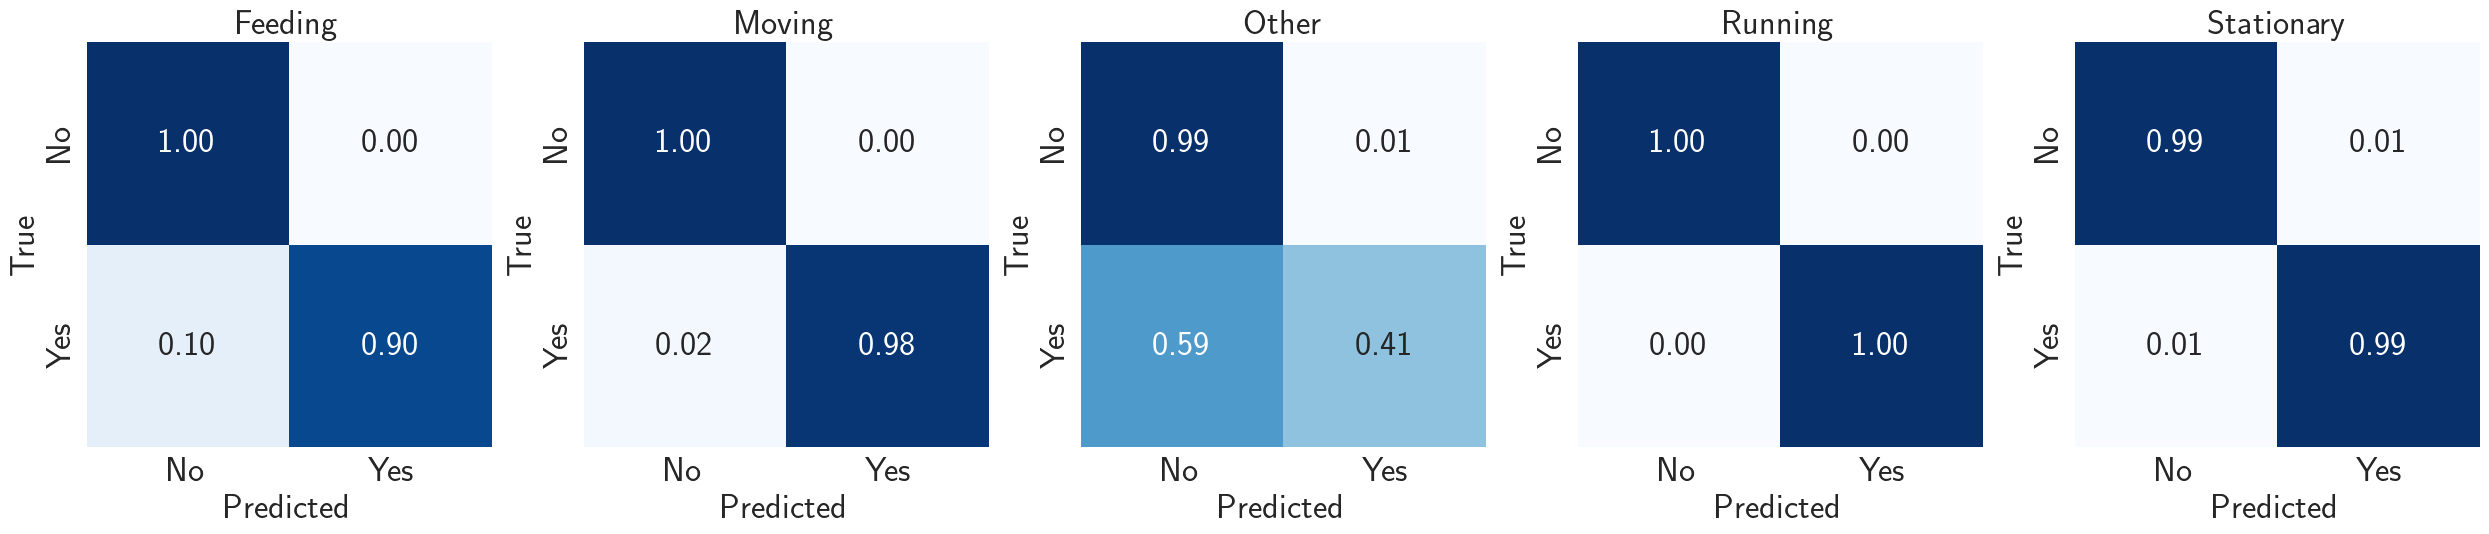

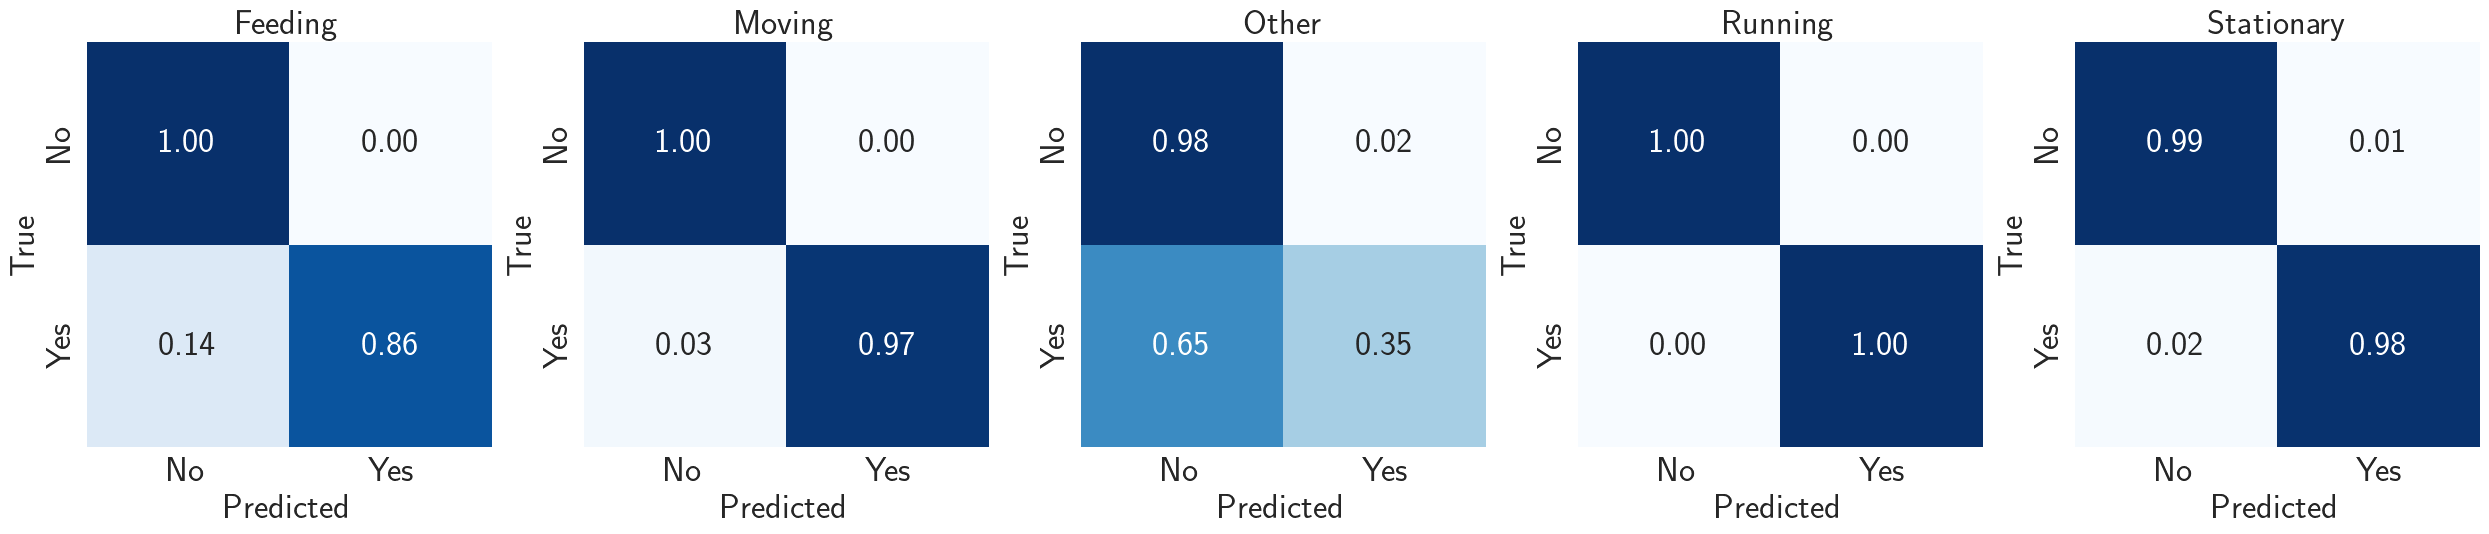

{}

In [148]:
model_name = 'B'
dir1 = os.path.join(io.get_domain_adaptation_results_dir(), "dann", model_name, "target1")
dir2 = os.path.join(io.get_domain_adaptation_results_dir(), "dann", model_name, "target2")

multi_label_predictions(dir1, label_encoder, split='test', plot_confusion=True, return_precision=False)
multi_label_predictions(dir2, label_encoder, split='test', plot_confusion=True, return_precision=False)


In [149]:
for row_idx, dir_path in enumerate([dir1]):

    # Load results
    results = np.load(os.path.join(dir_path, "test_results.npz"))
    y_true = results["true_classes"]        # shape: (N, C)
    y_pred = results["predictions"]         # shape: (N, C)
    print(np.sum(y_pred[np.where(y_true[:, 2] == 1)[0], :], axis=0))

[5 1 7 0 2]


In [150]:
hidden_dim = 128

for i, dir_path in enumerate([dir1, dir2]):

    feat = FeatureExtractor(in_dim=X_src.shape[-1], hidden_dim=hidden_dim).to(device)
    clf = LabelClassifier(in_dim=hidden_dim, n_classes=len(np.unique(y_src))).to(device)
    dom = DomainClassifier(in_dim=hidden_dim).to(device)
    dann_model = DANNModel(feat, clf, dom).to(device)
    dann_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=device))
    dann_model.to(device)

    
    _, _, _ = evaluate_multilabel_distribution(model=dann_model, 
                                    data=target_loaders[i],
                                    label_encoder=label_encoder,
                                    device=device, 
                                    threshold=0.5)
    
    

/tmp/ipykernel_981091/2568337154.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dann_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=d


Predicted class % occurrence:
  Feeding: 20.54%
  Moving: 9.35%
  Other: 5.30%
  Running: 3.33%
  Stationary: 57.49%


Evaluating: 100%|██████████| 4296/4296 [00:07<00:00, 544.97it/s]



Predicted class % occurrence:
  Feeding: 5.58%
  Moving: 13.81%
  Other: 6.95%
  Running: 6.33%
  Stationary: 64.93%


In [151]:
feat = FeatureExtractor(in_dim=X_src.shape[-1], hidden_dim=hidden_dim).to(device)
clf = LabelClassifier(in_dim=hidden_dim, n_classes=len(np.unique(y_src))).to(device)
dom = DomainClassifier(in_dim=hidden_dim).to(device)
dann_model2 = DANNModel(feat, clf, dom).to(device)
dann_model2.load_state_dict(torch.load(os.path.join(dir2, 'model.pt'), map_location=device))
dann_model2.to(device)

P2, cluster_scores2, unadjusted_label_dist2, adjusted_label_dist2, adjusted_scores2, predictions2 = calibration(cluster_dist2, cluster_centroids2, cluster_labels2, dann_model2, label_dist=label_dist, reg=0.1)

_ = make_sightings_plots_from_clusters(cluster_labels=cluster_labels2,
                                   cluster_scores=adjusted_scores2,
                                   data=transform(torch.tensor(X_targets[1][Vectronics_feature_cols].values, dtype=torch.float32)),
                                   metadata=X_targets[1],
                                   matched_sightings=sightings, 
                                   matched_gps=matched_gps,
                                   gps_clusters=gps_clusters,
                                   matched_gps_moving=gps_moving, 
                                   predictions=predictions2,
                                   plot_dir=os.path.join(io.get_sightings_dir(), "dann", model_name, 'calibrated'))

/tmp/ipykernel_981091/269704769.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dann_model2.load_state_dict(torch.load(os.path.join(dir2, 'model.pt'), map_location=devic

No. of GPS moving: 42
No. of GPS clusters: 54


Processing animal-days:   5%|▌         | 1/20 [00:03<01:11,  3.78s/it]

No. of GPS moving: 72
No. of GPS clusters: 51


Processing animal-days:  10%|█         | 2/20 [00:07<01:08,  3.82s/it]

No. of GPS moving: 41
No. of GPS clusters: 79


Processing animal-days:  15%|█▌        | 3/20 [00:11<01:04,  3.81s/it]

No. of GPS moving: 23
No. of GPS clusters: 66


Processing animal-days:  20%|██        | 4/20 [00:15<01:01,  3.83s/it]

No. of GPS moving: 51
No. of GPS clusters: 40


Processing animal-days:  25%|██▌       | 5/20 [00:18<00:55,  3.69s/it]

No. of GPS moving: 52
No. of GPS clusters: 56


Processing animal-days:  30%|███       | 6/20 [00:22<00:51,  3.69s/it]

No. of GPS moving: 61
No. of GPS clusters: 80


Processing animal-days:  35%|███▌      | 7/20 [00:26<00:49,  3.79s/it]

No. of GPS moving: 67
No. of GPS clusters: 50


Processing animal-days:  40%|████      | 8/20 [00:31<00:49,  4.16s/it]

No. of GPS moving: 59
No. of GPS clusters: 49


Processing animal-days:  45%|████▌     | 9/20 [00:35<00:45,  4.13s/it]

No. of GPS moving: 35
No. of GPS clusters: 61


Processing animal-days:  50%|█████     | 10/20 [00:38<00:39,  3.93s/it]

No. of GPS moving: 61
No. of GPS clusters: 79


Processing animal-days:  55%|█████▌    | 11/20 [00:42<00:34,  3.83s/it]

No. of GPS moving: 58
No. of GPS clusters: 99


Processing animal-days:  60%|██████    | 12/20 [00:46<00:30,  3.83s/it]

No. of GPS moving: 45
No. of GPS clusters: 88


Processing animal-days:  65%|██████▌   | 13/20 [00:50<00:26,  3.84s/it]

No. of GPS moving: 68
No. of GPS clusters: 85


Processing animal-days:  70%|███████   | 14/20 [00:54<00:23,  3.93s/it]

No. of GPS moving: 76
No. of GPS clusters: 67


Processing animal-days:  75%|███████▌  | 15/20 [00:58<00:19,  3.95s/it]

No. of GPS moving: 50
No. of GPS clusters: 91


Processing animal-days:  80%|████████  | 16/20 [01:02<00:16,  4.06s/it]

No. of GPS moving: 63
No. of GPS clusters: 53


Processing animal-days:  85%|████████▌ | 17/20 [01:06<00:11,  3.96s/it]

No. of GPS moving: 41
No. of GPS clusters: 84


Processing animal-days:  90%|█████████ | 18/20 [01:10<00:07,  3.89s/it]

No. of GPS moving: 48
No. of GPS clusters: 132


Processing animal-days:  95%|█████████▌| 19/20 [01:14<00:03,  3.89s/it]

No. of GPS moving: 65
No. of GPS clusters: 97


Processing animal-days: 100%|██████████| 20/20 [01:17<00:00,  3.90s/it]


#### Model C

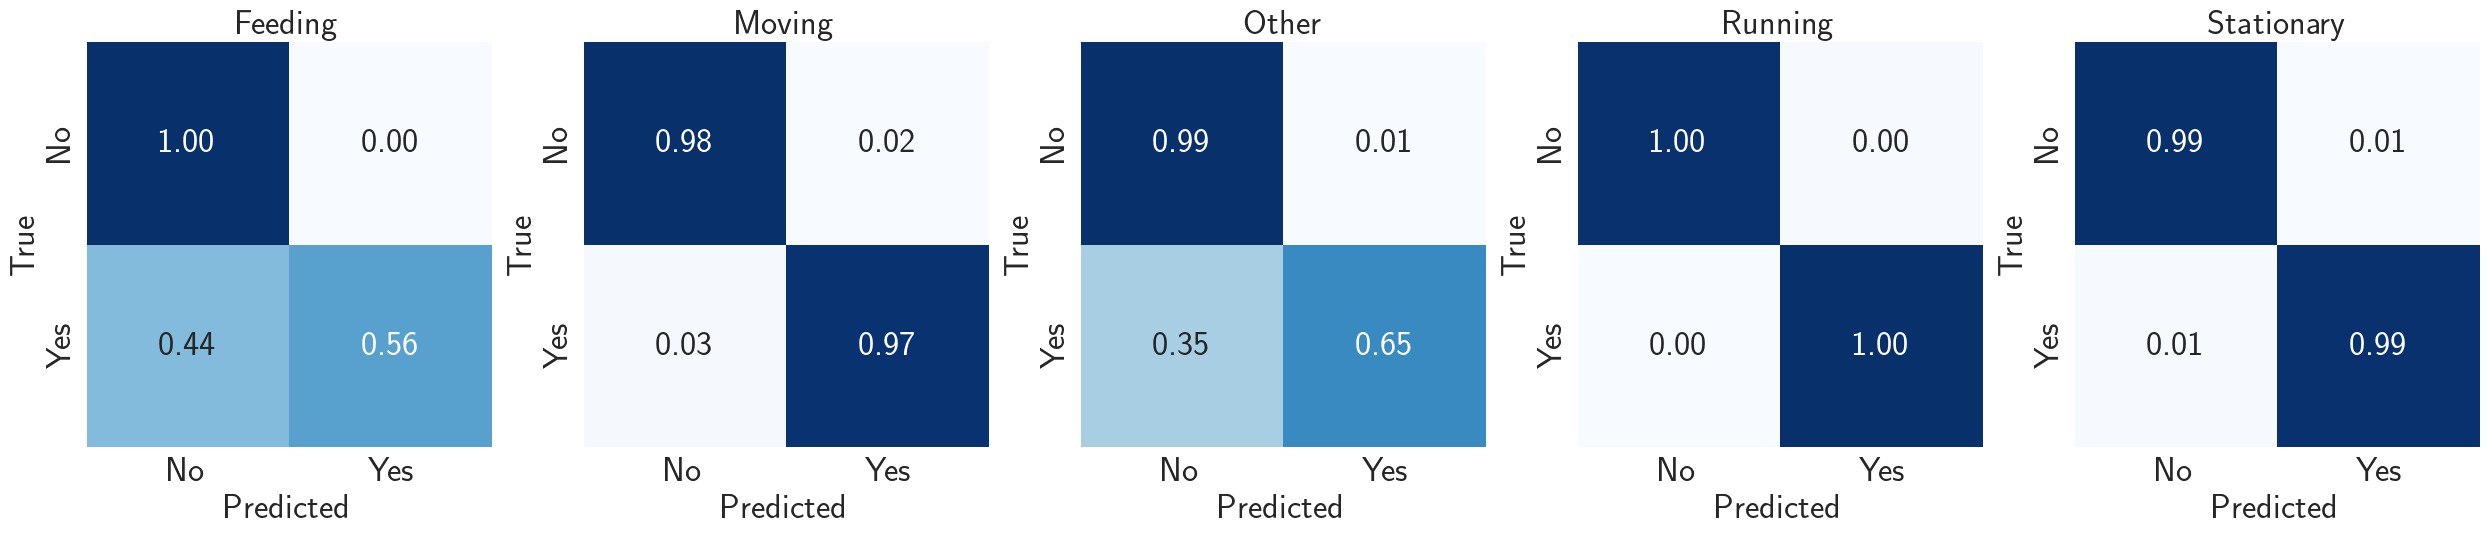

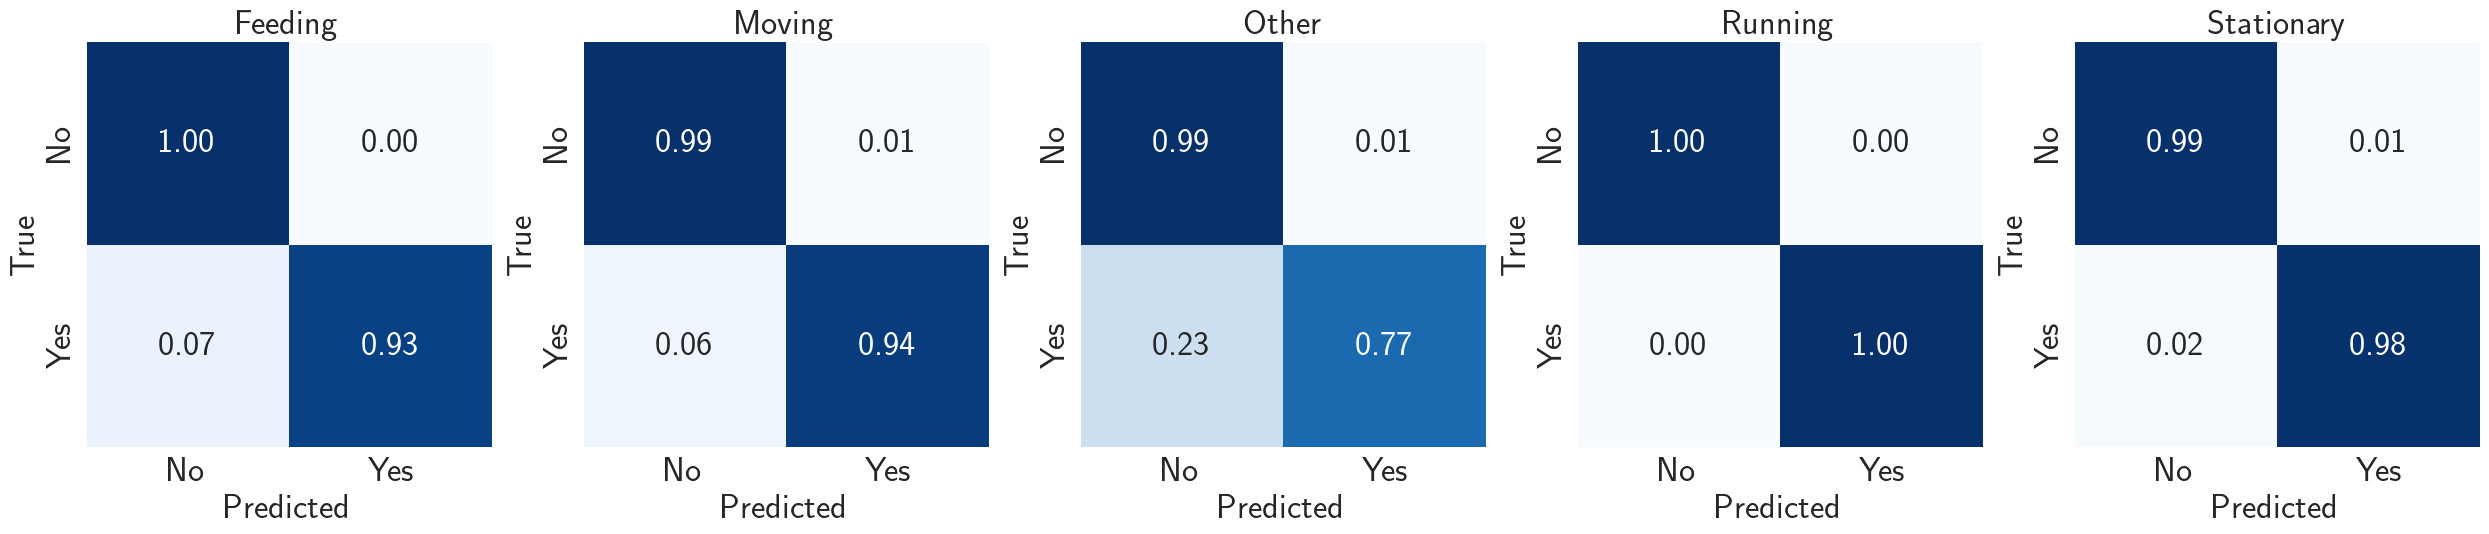

{}

In [152]:
model_name = 'C'
dir1 = os.path.join(io.get_domain_adaptation_results_dir(), "dann", model_name, "target1")
dir2 = os.path.join(io.get_domain_adaptation_results_dir(), "dann", model_name, "target2")

multi_label_predictions(dir1, label_encoder, split='test', plot_confusion=True, return_precision=False)
multi_label_predictions(dir2, label_encoder, split='test', plot_confusion=True, return_precision=False)


In [153]:
for row_idx, dir_path in enumerate([dir1]):

    # Load results
    results = np.load(os.path.join(dir_path, "test_results.npz"))
    y_true = results["true_classes"]        # shape: (N, C)
    y_pred = results["predictions"]         # shape: (N, C)
    print(np.sum(y_pred[np.where(y_true[:, 2] == 1)[0], :], axis=0))

[ 5 23 54  1  3]


In [154]:
hidden_dim = 128

for i, dir_path in enumerate([dir1, dir2]):

    feat = FeatureExtractor(in_dim=X_src.shape[-1], hidden_dim=hidden_dim).to(device)
    clf = LabelClassifier(in_dim=hidden_dim, n_classes=len(np.unique(y_src))).to(device)
    dom = DomainClassifier(in_dim=hidden_dim).to(device)
    dann_model = DANNModel(feat, clf, dom).to(device)
    dann_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=device))
    dann_model.to(device)

    
    _, _, _ = evaluate_multilabel_distribution(model=dann_model, 
                                    data=target_loaders[i],
                                    label_encoder=label_encoder,
                                    device=device, 
                                    threshold=0.5)
    
    

/tmp/ipykernel_981091/2568337154.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dann_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=d


Predicted class % occurrence:
  Feeding: 12.59%
  Moving: 7.40%
  Other: 14.44%
  Running: 4.82%
  Stationary: 57.74%


Evaluating: 100%|██████████| 4296/4296 [00:21<00:00, 200.75it/s]


Predicted class % occurrence:
  Feeding: 5.34%
  Moving: 11.15%
  Other: 7.85%
  Running: 6.15%
  Stationary: 66.20%


In [155]:
feat = FeatureExtractor(in_dim=X_src.shape[-1], hidden_dim=hidden_dim).to(device)
clf = LabelClassifier(in_dim=hidden_dim, n_classes=len(np.unique(y_src))).to(device)
dom = DomainClassifier(in_dim=hidden_dim).to(device)
dann_model2 = DANNModel(feat, clf, dom).to(device)
dann_model2.load_state_dict(torch.load(os.path.join(dir2, 'model.pt'), map_location=device))
dann_model2.to(device)

P2, cluster_scores2, unadjusted_label_dist2, adjusted_label_dist2, adjusted_scores2, predictions2 = calibration(cluster_dist2, cluster_centroids2, cluster_labels2, dann_model2, label_dist=label_dist, reg=0.1)

_ = make_sightings_plots_from_clusters(cluster_labels=cluster_labels2,
                                   cluster_scores=adjusted_scores2,
                                   data=transform(torch.tensor(X_targets[1][Vectronics_feature_cols].values, dtype=torch.float32)),
                                   metadata=X_targets[1],
                                   matched_sightings=sightings, 
                                   matched_gps=matched_gps,
                                   gps_clusters=gps_clusters,
                                   matched_gps_moving=gps_moving, 
                                   predictions=predictions2,
                                   plot_dir=os.path.join(io.get_sightings_dir(), "dann", model_name, 'calibrated'))

/tmp/ipykernel_981091/269704769.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dann_model2.load_state_dict(torch.load(os.path.join(dir2, 'model.pt'), map_location=devic

No. of GPS moving: 42
No. of GPS clusters: 54


Processing animal-days:   5%|▌         | 1/20 [00:05<01:42,  5.39s/it]

No. of GPS moving: 72
No. of GPS clusters: 51


Processing animal-days:  10%|█         | 2/20 [00:12<01:52,  6.28s/it]

No. of GPS moving: 41
No. of GPS clusters: 79


Processing animal-days:  15%|█▌        | 3/20 [00:18<01:46,  6.25s/it]

No. of GPS moving: 23
No. of GPS clusters: 66


Processing animal-days:  20%|██        | 4/20 [00:26<01:47,  6.75s/it]

No. of GPS moving: 51
No. of GPS clusters: 40


Processing animal-days:  25%|██▌       | 5/20 [00:31<01:35,  6.35s/it]

No. of GPS moving: 52
No. of GPS clusters: 56


Processing animal-days:  30%|███       | 6/20 [00:37<01:26,  6.18s/it]

No. of GPS moving: 61
No. of GPS clusters: 80


Processing animal-days:  35%|███▌      | 7/20 [00:43<01:20,  6.21s/it]

No. of GPS moving: 67
No. of GPS clusters: 50


Processing animal-days:  40%|████      | 8/20 [00:49<01:13,  6.11s/it]

No. of GPS moving: 59
No. of GPS clusters: 49


Processing animal-days:  45%|████▌     | 9/20 [00:55<01:06,  6.05s/it]

No. of GPS moving: 35
No. of GPS clusters: 61


Processing animal-days:  50%|█████     | 10/20 [01:00<00:58,  5.82s/it]

No. of GPS moving: 61
No. of GPS clusters: 79


Processing animal-days:  55%|█████▌    | 11/20 [01:07<00:54,  6.07s/it]

No. of GPS moving: 58
No. of GPS clusters: 99


Processing animal-days:  60%|██████    | 12/20 [01:13<00:47,  5.99s/it]

No. of GPS moving: 45
No. of GPS clusters: 88


Processing animal-days:  65%|██████▌   | 13/20 [01:19<00:41,  5.93s/it]

No. of GPS moving: 68
No. of GPS clusters: 85


Processing animal-days:  70%|███████   | 14/20 [01:25<00:35,  5.99s/it]

No. of GPS moving: 76
No. of GPS clusters: 67


Processing animal-days:  75%|███████▌  | 15/20 [01:31<00:30,  6.06s/it]

No. of GPS moving: 50
No. of GPS clusters: 91


Processing animal-days:  80%|████████  | 16/20 [01:37<00:23,  5.98s/it]

No. of GPS moving: 63
No. of GPS clusters: 53


Processing animal-days:  85%|████████▌ | 17/20 [01:43<00:17,  5.95s/it]

No. of GPS moving: 41
No. of GPS clusters: 84


Processing animal-days:  90%|█████████ | 18/20 [01:48<00:11,  5.80s/it]

No. of GPS moving: 48
No. of GPS clusters: 132


Processing animal-days:  95%|█████████▌| 19/20 [01:55<00:06,  6.11s/it]

No. of GPS moving: 65
No. of GPS clusters: 97


Processing animal-days: 100%|██████████| 20/20 [02:01<00:00,  6.08s/it]


## Method: FixMatch (Self-supervised learning)

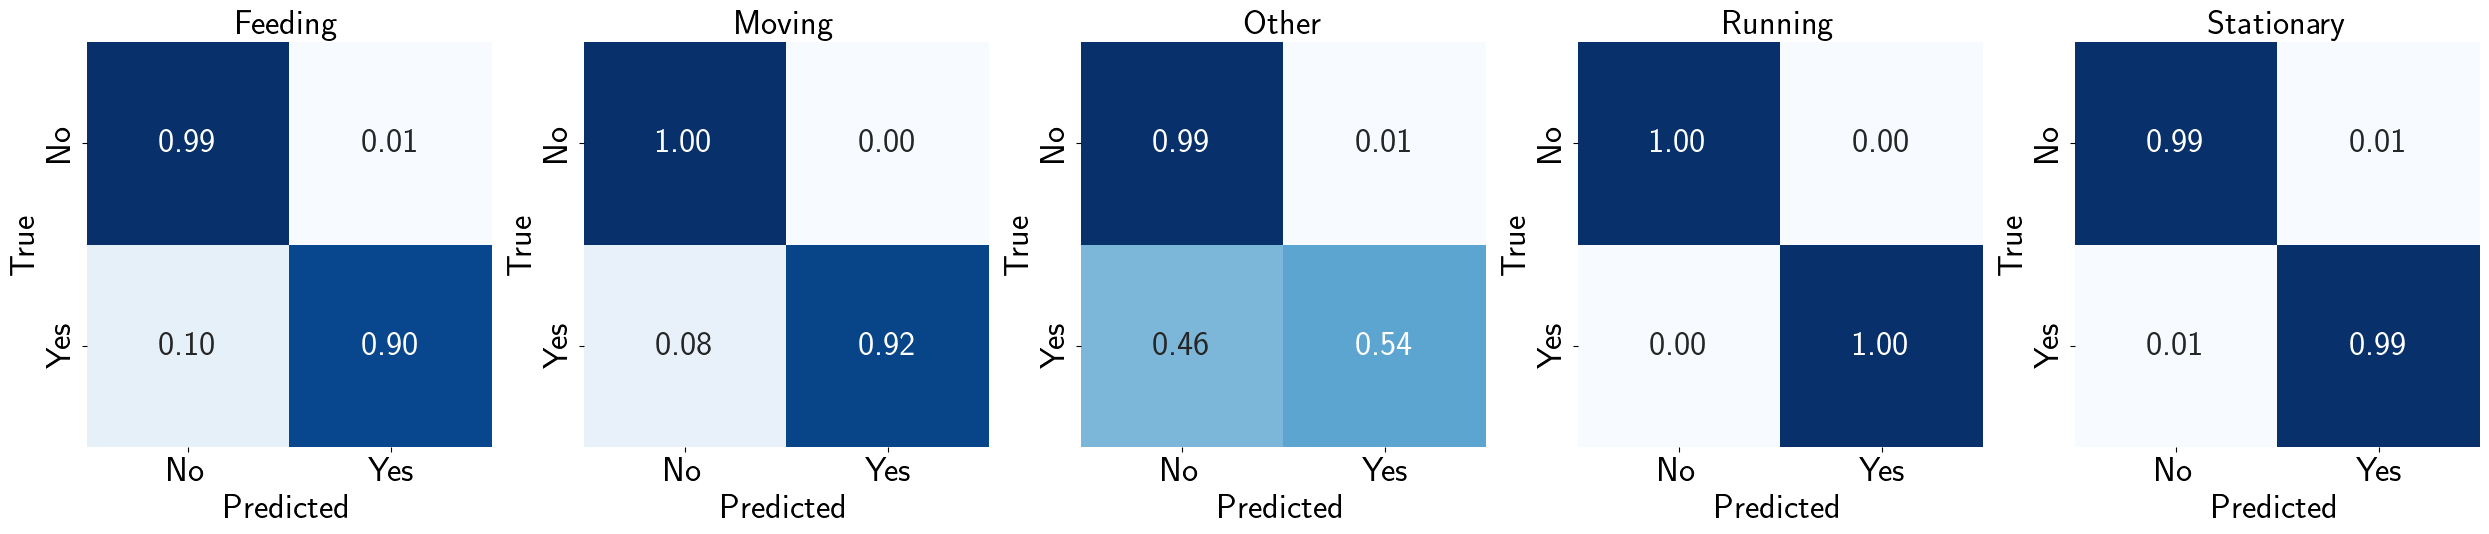

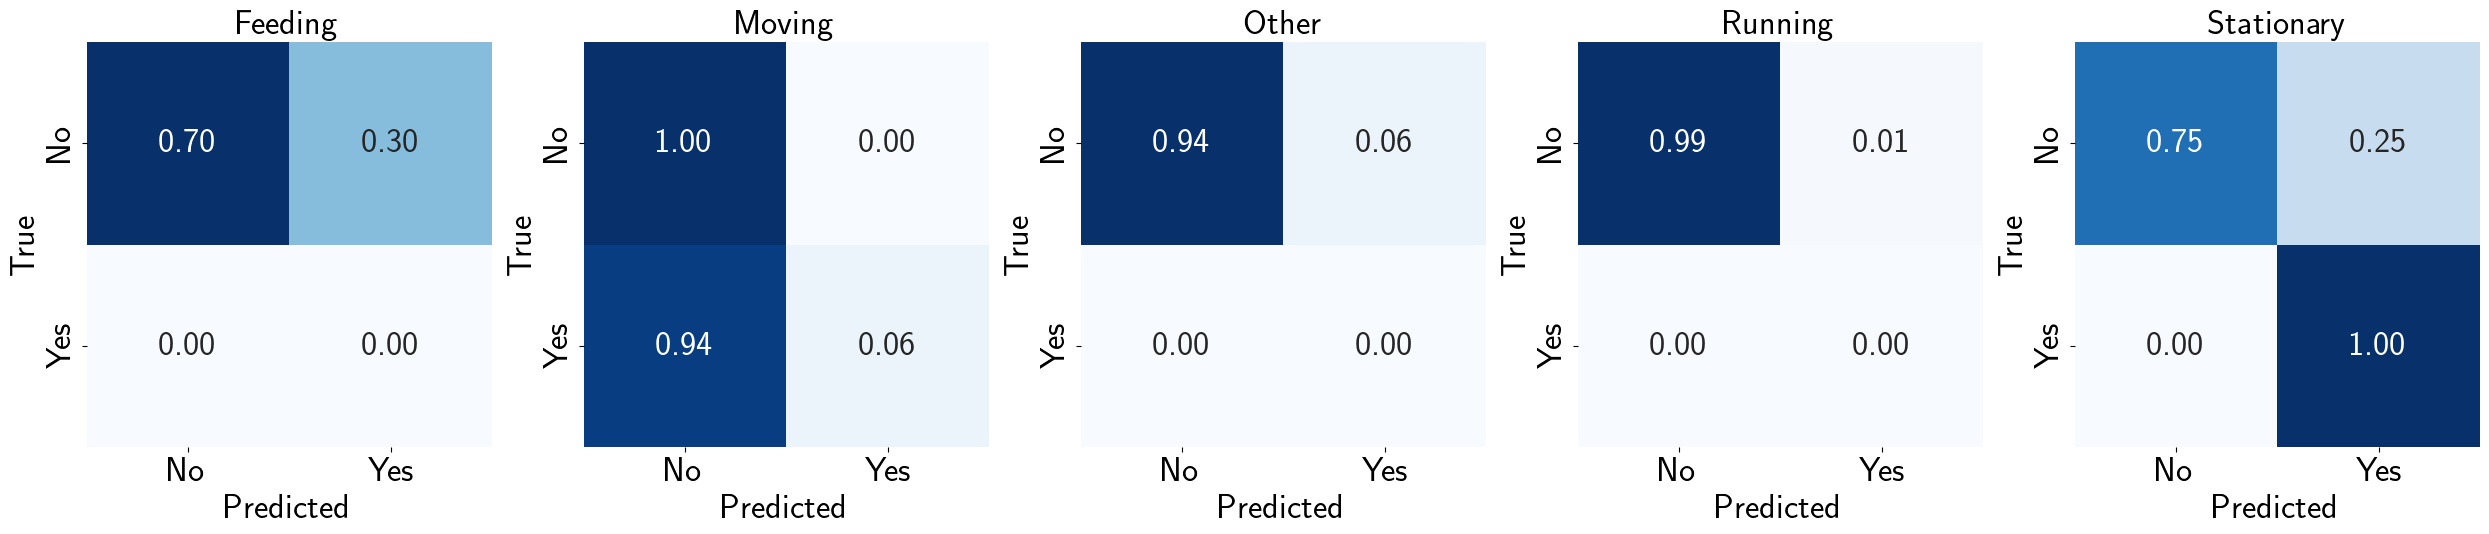

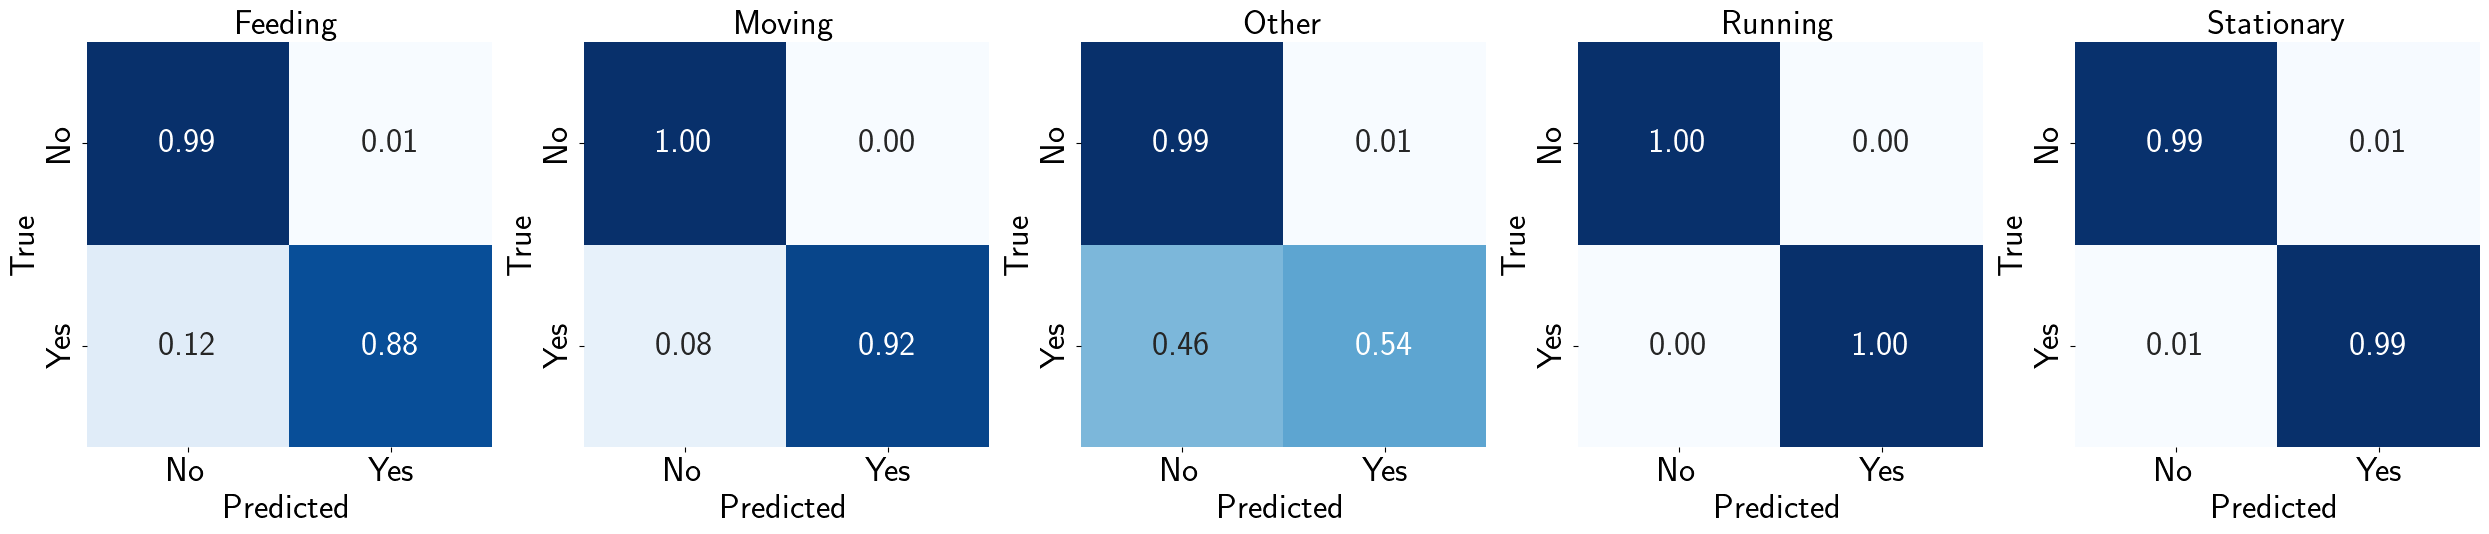

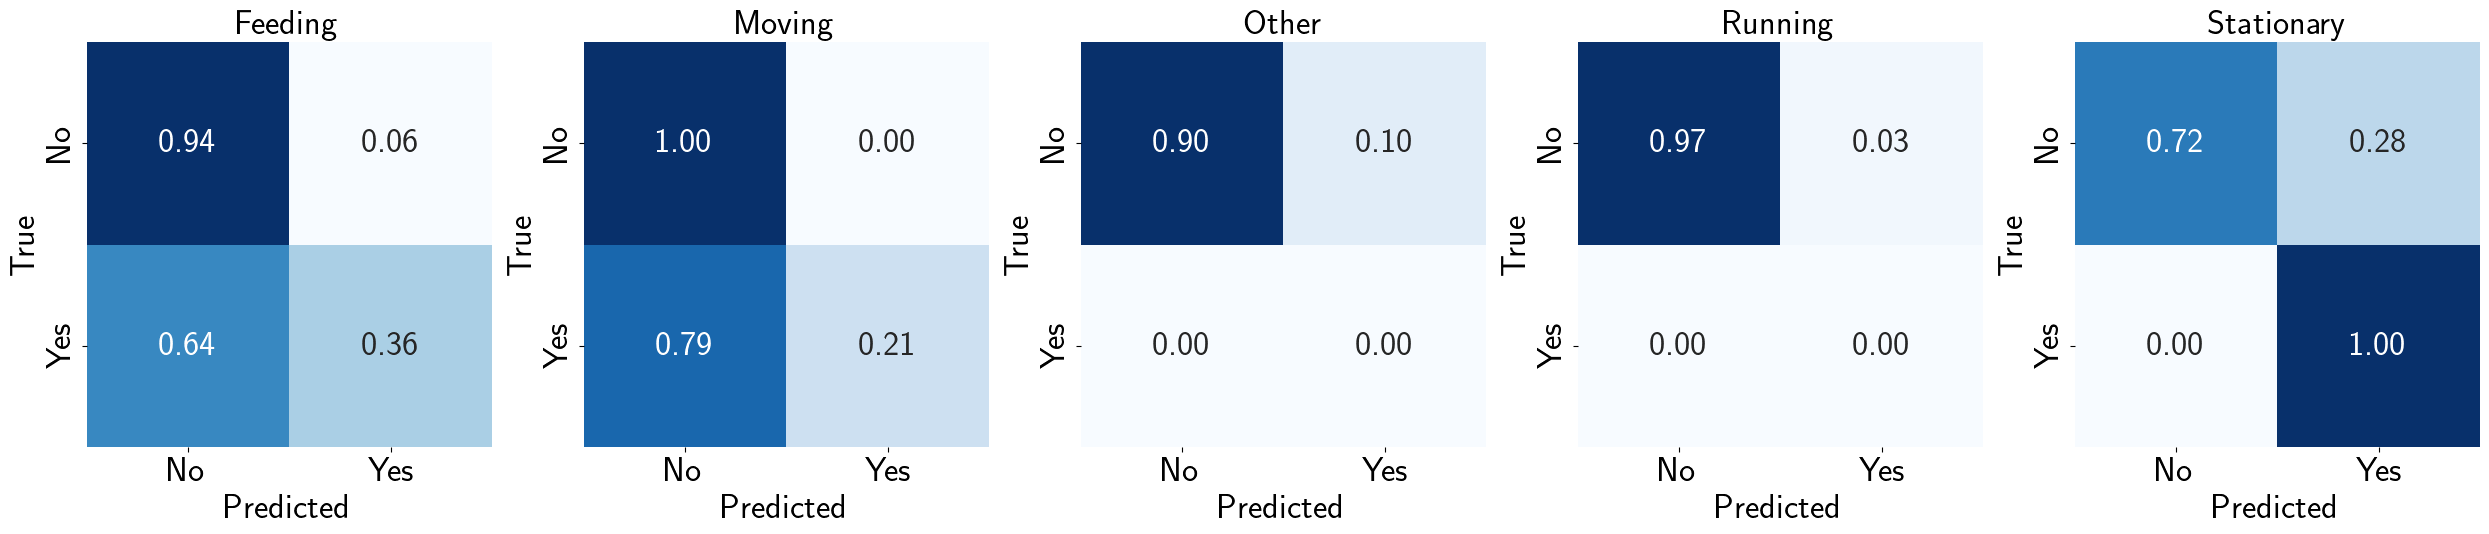

{}

In [54]:
model_name = 'A'
dir1 = os.path.join(io.get_domain_adaptation_results_dir(), "fixmatch_self_supervised", model_name, "target1")
dir2 = os.path.join(io.get_domain_adaptation_results_dir(), "fixmatch_self_supervised", model_name, "target2")

multi_label_predictions(dir1, label_encoder, split='test', plot_confusion=True, return_precision=False)
multi_label_predictions(dir1, label_encoder, split='target_test', plot_confusion=True, return_precision=False)

multi_label_predictions(dir2, label_encoder, split='test', plot_confusion=True, return_precision=False)
multi_label_predictions(dir2, label_encoder, split='target_test', plot_confusion=True, return_precision=False)



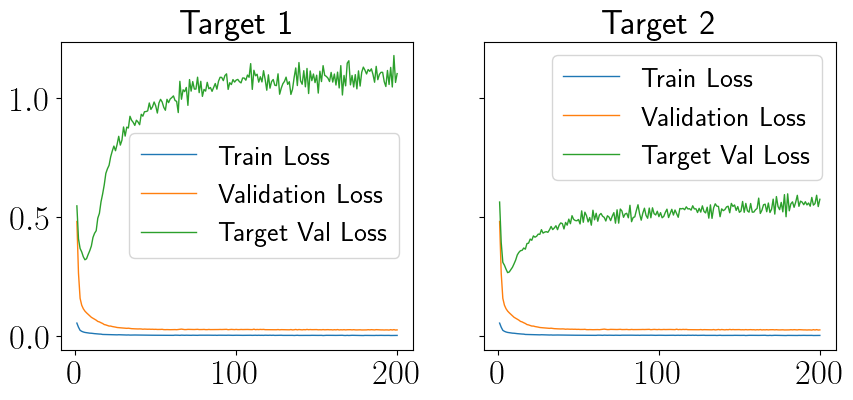

In [52]:
with open(os.path.join(dir1, "training_stats.json"), "r") as f:
    data = json.load(f)
train_loss1 = [a['Training Loss'] for a in data]
val_loss1 = [a['Validation Loss'] for a in data]
target_val_loss1 = [a['Target Validation Loss'] for a in data]


with open(os.path.join(dir2, "training_stats.json"), "r") as f:
    data = json.load(f)
train_loss2 = [a['Training Loss'] for a in data]
val_loss2 = [a['Validation Loss'] for a in data]
target_val_loss2 = [a['Target Validation Loss'] for a in data]


fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)
axs[0].plot(np.arange(1, len(train_loss1)+1), train_loss1, label='Train Loss')
axs[0].plot(np.arange(1, len(val_loss1)+1), val_loss1, label='Validation Loss')
axs[0].plot(np.arange(1, len(target_val_loss1)+1), target_val_loss1, label='Target Val Loss')
axs[0].set_title("Target 1")
axs[0].legend()

axs[1].plot(np.arange(1, len(train_loss1)+1), train_loss1, label='Train Loss')
axs[1].plot(np.arange(1, len(val_loss1)+1), val_loss1, label='Validation Loss')
axs[1].plot(np.arange(1, len(target_val_loss2)+1), target_val_loss2, label='Target Val Loss')
axs[1].set_title("Target 2")
axs[1].legend()
plt.show()

In [33]:
feat_dim = 128

for i, dir_path in enumerate([dir1, dir2]):
    fixmatch_model = SimpleFeatureNet(X_src.shape[-1], feat_dim, len(np.unique(y_src)))
    fixmatch_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=device))
    fixmatch_model.to(device)

    _, _, _ = evaluate_multilabel_distribution(model=fixmatch_model, 
                                    data=target_loaders[i],
                                    label_encoder=label_encoder,
                                    device=device, 
                                    threshold=0.5)
    
    _, _, _ = evaluate_multilabel_distribution(model=fixmatch_model, 
                                    data=source_loader,
                                    label_encoder=label_encoder,
                                    device=device, 
                                    threshold=0.5)

/tmp/ipykernel_755481/2820170939.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fixmatch_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_locati


Predicted class % occurrence:
  Feeding: 20.79%
  Moving: 2.70%
  Other: 18.89%
  Running: 0.88%
  Stationary: 63.31%

Predicted class % occurrence:
  Feeding: 1.07%
  Moving: 8.51%
  Other: 4.07%
  Running: 1.50%
  Stationary: 86.93%


/tmp/ipykernel_755481/2820170939.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fixmatch_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_locati


Predicted class % occurrence:
  Feeding: 8.17%
  Moving: 11.67%
  Other: 9.47%
  Running: 4.05%
  Stationary: 73.22%

Predicted class % occurrence:
  Feeding: 1.18%
  Moving: 8.69%
  Other: 3.84%
  Running: 1.62%
  Stationary: 86.83%


/tmp/ipykernel_712905/3526565161.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fixmatch_model.load_state_dict(torch.load(os.path.join(dir2, 'model.pt'), map_location=d

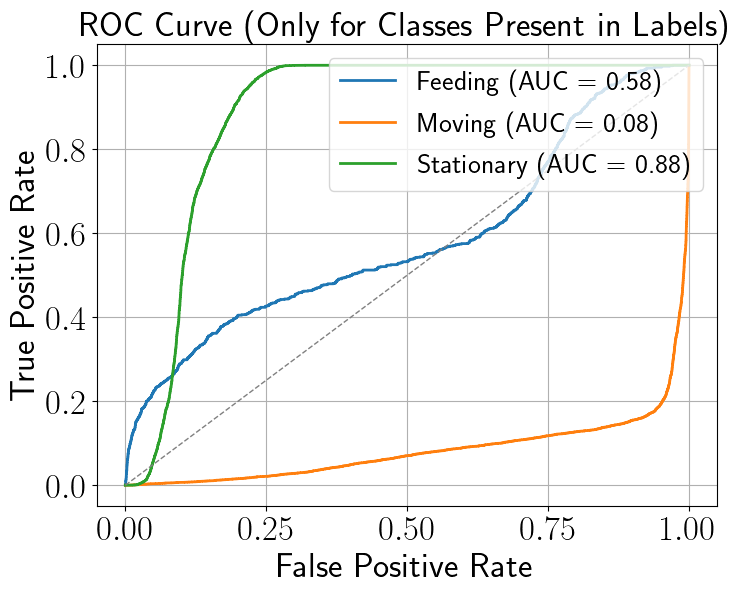

In [55]:
fixmatch_model = SimpleFeatureNet(X_src.shape[-1], feat_dim, len(np.unique(y_src)))
fixmatch_model.load_state_dict(torch.load(os.path.join(dir2, 'model.pt'), map_location=device))
fixmatch_model.to(device)

with torch.no_grad():
    _, logits = fixmatch_model(torch.tensor(X_sightings_test_set, dtype=torch.float32).to(device))
    predictions = torch.sigmoid(logits).detach().cpu().numpy()

plot_multiclass_roc(y_sightings_test_set, predictions, label_encoder=label_encoder)

In [40]:
fixmatch_model = SimpleFeatureNet(X_src.shape[-1], feat_dim, len(np.unique(y_src)))
fixmatch_model.load_state_dict(torch.load(os.path.join(dir2, 'model.pt'), map_location=device))
fixmatch_model.to(device)

P2, cluster_scores2, unadjusted_label_dist2, adjusted_label_dist2, adjusted_scores2, predictions2 = calibration(cluster_dist2, 
                                                                                                                cluster_centroids2, 
                                                                                                                cluster_labels2, 
                                                                                                                fixmatch_model, 
                                                                                                                label_dist=label_dist, reg=reg)
plot_dir = os.path.join(io.get_sightings_dir(), "fixmatch_self_supervised", model_name, "calibrated")
_ = make_sightings_plots_from_clusters(cluster_labels=cluster_labels2,
                                   cluster_scores=adjusted_scores2,
                                   data=transform(torch.tensor(X_targets[1][Vectronics_feature_cols].values, dtype=torch.float32)),
                                   metadata=X_targets[1],
                                   matched_sightings=sightings, 
                                   matched_gps=matched_gps,
                                   gps_clusters=gps_clusters,
                                   matched_gps_moving=gps_moving, 
                                   predictions=predictions2,
                                   plot_dir=plot_dir,
                                   save_predictions=True)


/tmp/ipykernel_755481/3957330237.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fixmatch_model.load_state_dict(torch.load(os.path.join(dir2, 'model.pt'), map_location=d

## Method: FixMatch Model (Semi-supervised Learning, $\lambda = 1.0$)

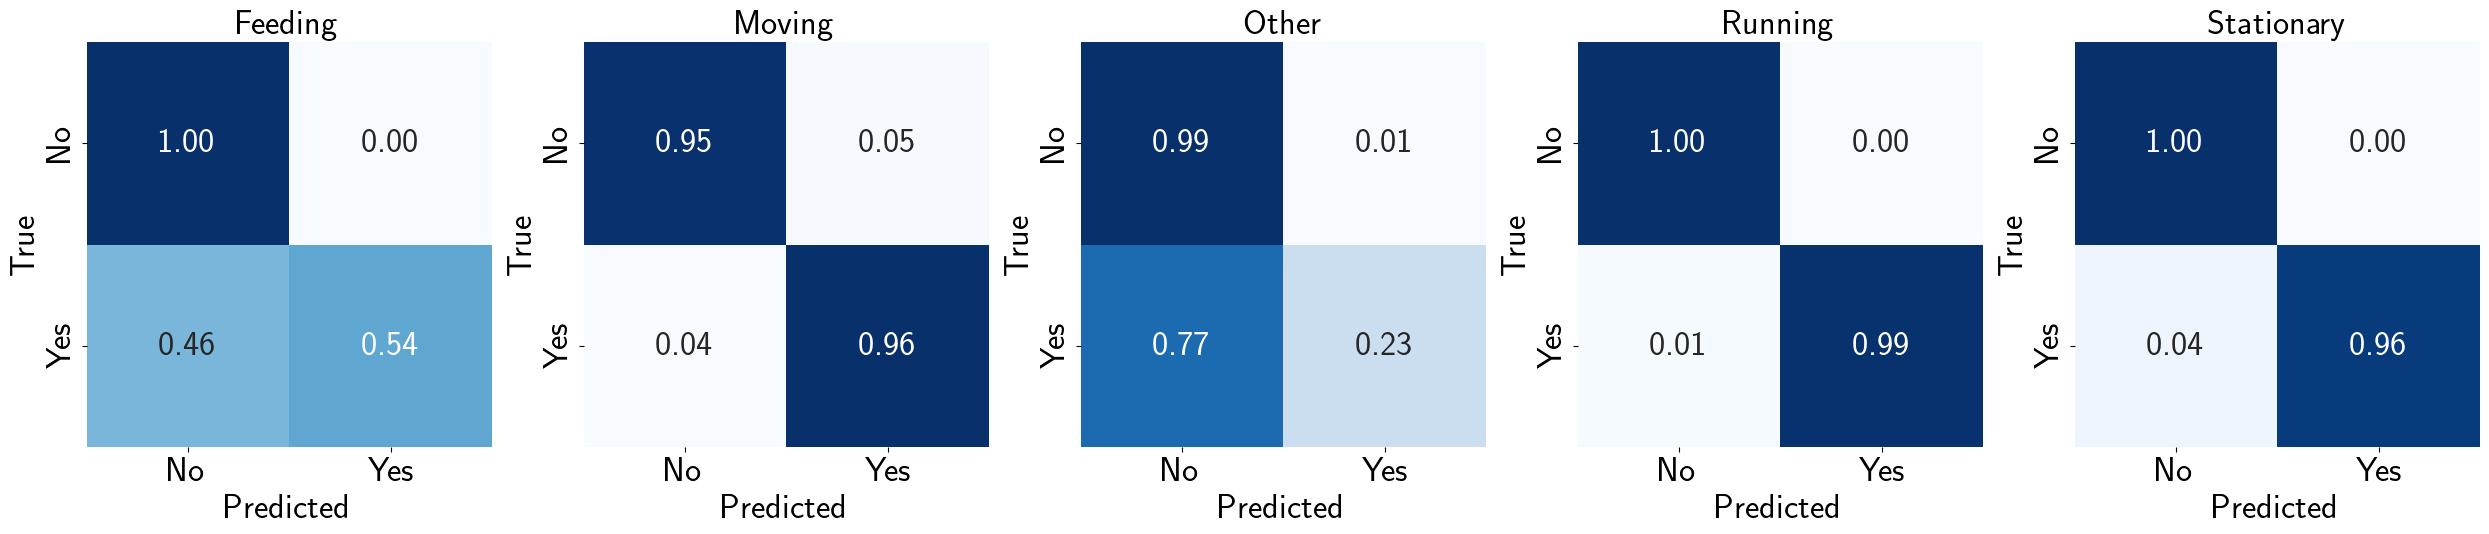

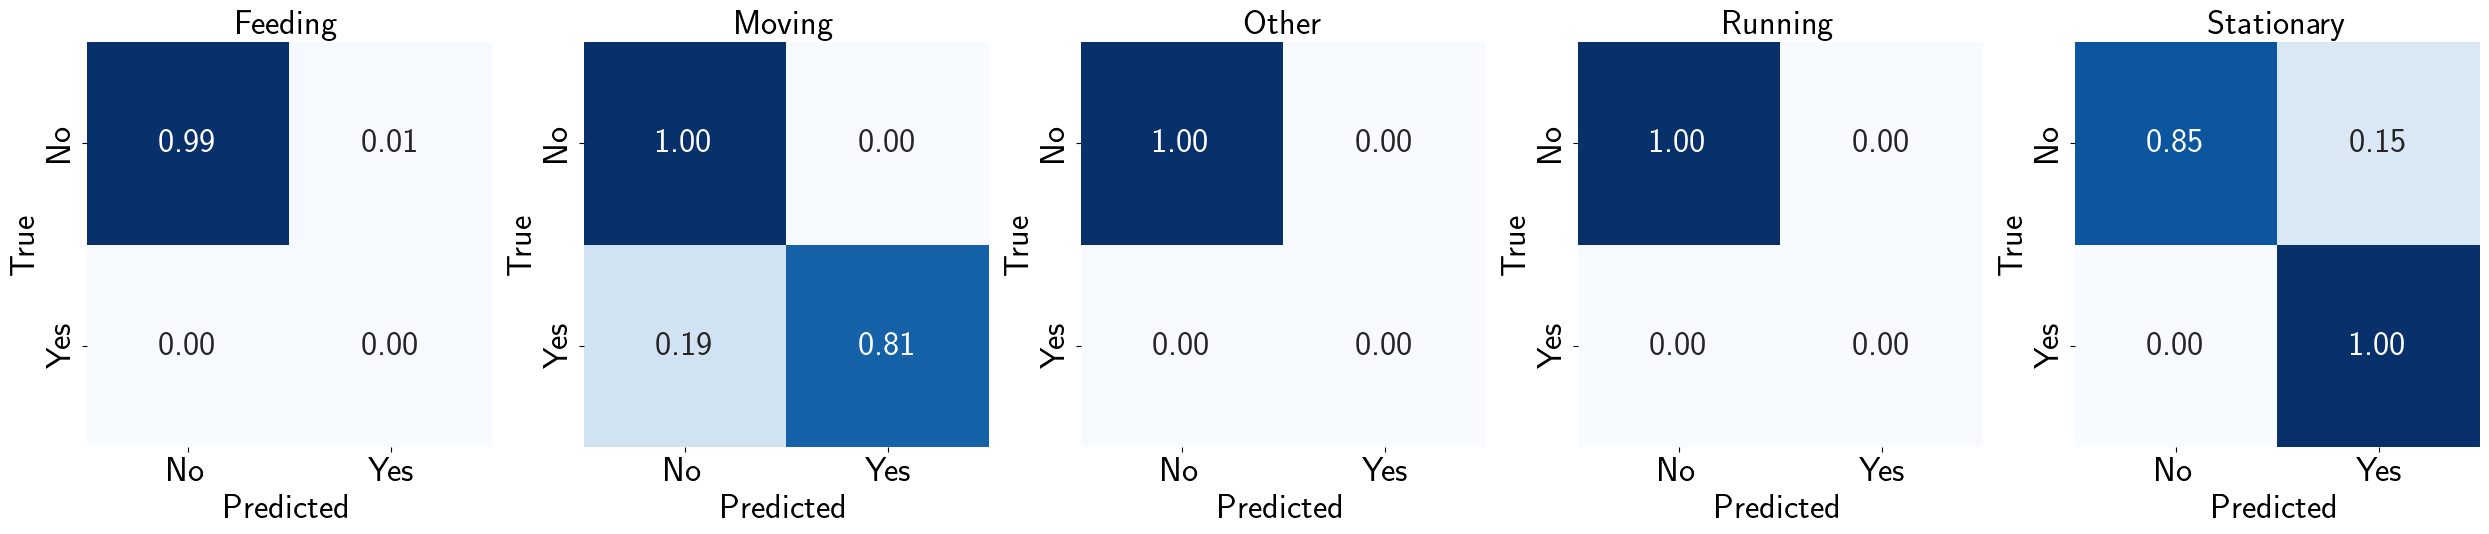

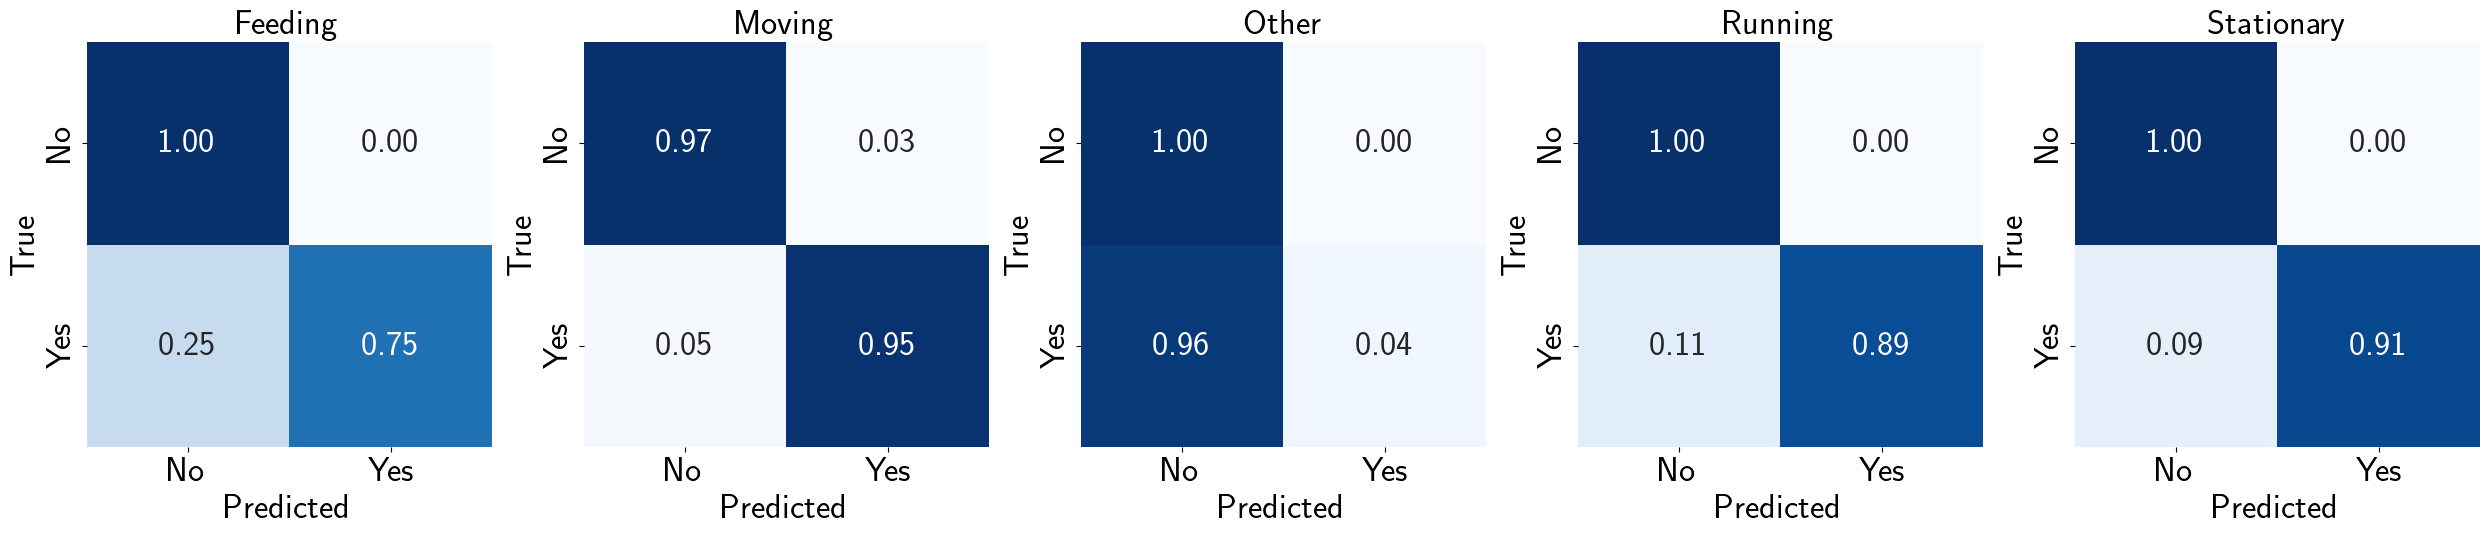

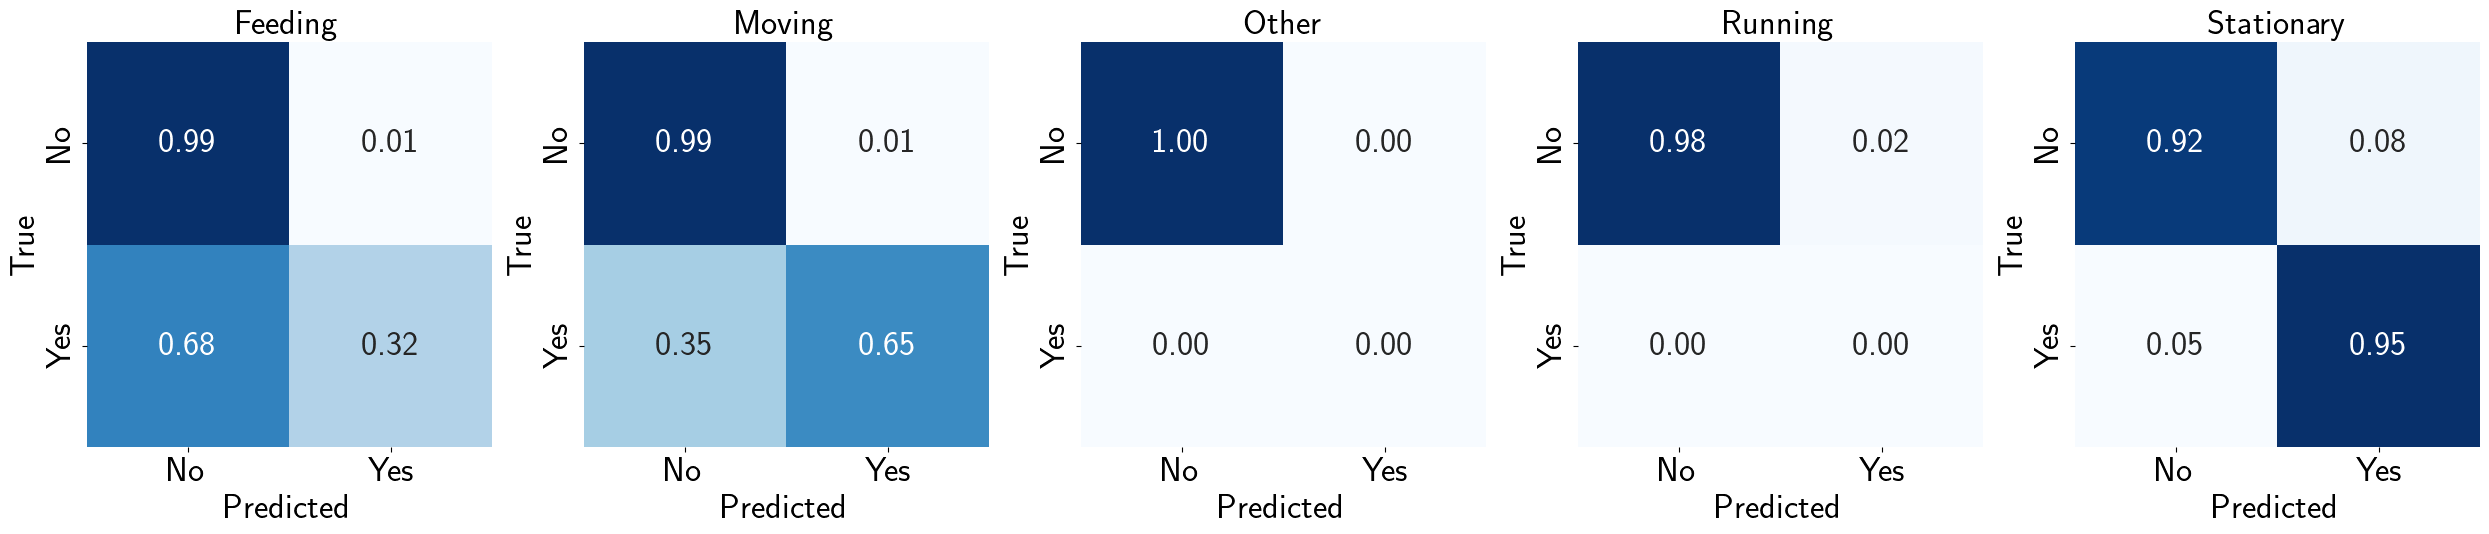

{}

In [19]:
model_name = 'A'
dir1 = os.path.join(io.get_domain_adaptation_results_dir(), "fixmatch_semi_supervised", "lambda2.0", model_name, "target1")
dir2 = os.path.join(io.get_domain_adaptation_results_dir(), "fixmatch_semi_supervised",  "lambda2.0", model_name, "target2")

multi_label_predictions(dir1, label_encoder, split='test', plot_confusion=True, return_precision=False)
multi_label_predictions(dir1, label_encoder, split='target_test', plot_confusion=True, return_precision=False)

multi_label_predictions(dir2, label_encoder, split='test', plot_confusion=True, return_precision=False)
multi_label_predictions(dir2, label_encoder, split='target_test', plot_confusion=True, return_precision=False)



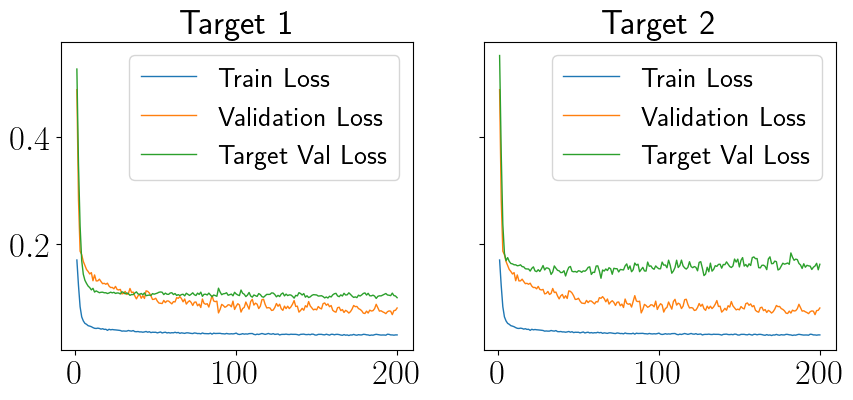

In [20]:
with open(os.path.join(dir1, "training_stats.json"), "r") as f:
    data = json.load(f)
train_loss1 = [a['Training Loss'] for a in data]
val_loss1 = [a['Validation Loss'] for a in data]
target_val_loss1 = [a['Target Validation Loss'] for a in data]


with open(os.path.join(dir2, "training_stats.json"), "r") as f:
    data = json.load(f)
train_loss2 = [a['Training Loss'] for a in data]
val_loss2 = [a['Validation Loss'] for a in data]
target_val_loss2 = [a['Target Validation Loss'] for a in data]


fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)
axs[0].plot(np.arange(1, len(train_loss1)+1), train_loss1, label='Train Loss')
axs[0].plot(np.arange(1, len(val_loss1)+1), val_loss1, label='Validation Loss')
axs[0].plot(np.arange(1, len(target_val_loss1)+1), target_val_loss1, label='Target Val Loss')
axs[0].set_title("Target 1")
axs[0].legend()

axs[1].plot(np.arange(1, len(train_loss1)+1), train_loss1, label='Train Loss')
axs[1].plot(np.arange(1, len(val_loss1)+1), val_loss1, label='Validation Loss')
axs[1].plot(np.arange(1, len(target_val_loss2)+1), target_val_loss2, label='Target Val Loss')
axs[1].set_title("Target 2")
axs[1].legend()
plt.show()

/tmp/ipykernel_767005/3526565161.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fixmatch_model.load_state_dict(torch.load(os.path.join(dir2, 'model.pt'), map_location=d

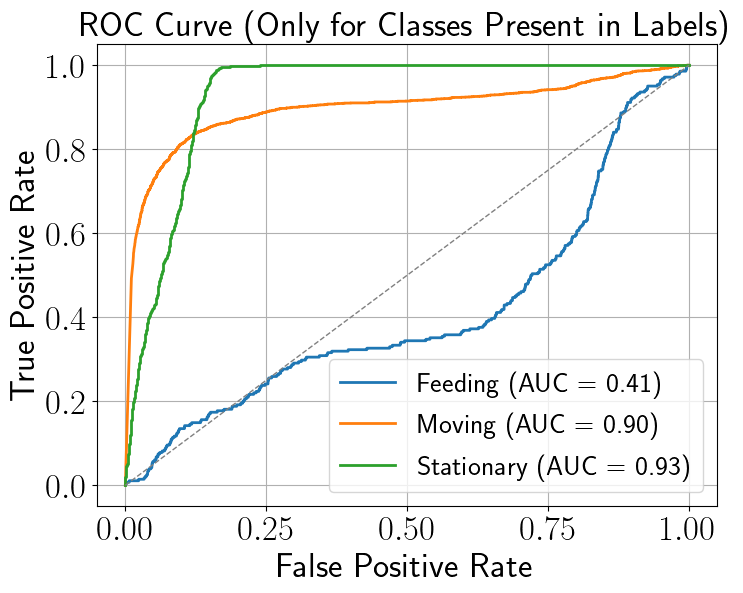

In [21]:
fixmatch_model = SimpleFeatureNet(X_src.shape[-1], feat_dim, len(np.unique(y_src)))
fixmatch_model.load_state_dict(torch.load(os.path.join(dir2, 'model.pt'), map_location=device))
fixmatch_model.to(device)

with torch.no_grad():
    _, logits = fixmatch_model(torch.tensor(X_sightings_test_set, dtype=torch.float32).to(device))
    predictions = torch.sigmoid(logits).detach().cpu().numpy()

plot_multiclass_roc(y_sightings_test_set, predictions, label_encoder=label_encoder)

In [70]:
fixmatch_model = SimpleFeatureNet(X_src.shape[-1], feat_dim, len(np.unique(y_src)))
fixmatch_model.load_state_dict(torch.load(os.path.join(dir2, 'model.pt'), map_location=device))
fixmatch_model.to(device)

P2, cluster_scores2, unadjusted_label_dist2, adjusted_label_dist2, adjusted_scores2, predictions2 = calibration(cluster_dist2, 
                                                                                                                cluster_centroids2, 
                                                                                                                cluster_labels2, 
                                                                                                                fixmatch_model, 
                                                                                                                label_dist=label_dist, reg=reg)
plot_dir = os.path.join(io.get_sightings_dir(), "fixmatch_semi_supervised", "lambda1.0", model_name, "calibrated")
print(plot_dir)
_ = make_sightings_plots_from_clusters(cluster_labels=cluster_labels2,
                                   cluster_scores=adjusted_scores2,
                                   data=transform(torch.tensor(X_targets[1][Vectronics_feature_cols].values, dtype=torch.float32)),
                                   metadata=X_targets[1],
                                   matched_sightings=sightings, 
                                   matched_gps=matched_gps,
                                   gps_clusters=gps_clusters,
                                   matched_gps_moving=gps_moving, 
                                   predictions=predictions2,
                                   plot_dir=plot_dir,
                                   save_predictions=True)


/tmp/ipykernel_755481/111489766.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fixmatch_model.load_state_dict(torch.load(os.path.join(dir2, 'model.pt'), map_location=de

/home/medhaaga/BotswanaML/results/sightings/fixmatch_semi_supervised/lambda1.0/C/calibrated
